# Udacity Data Science Nanodegree
# Project 2: Software Engineering - Creating a webapp

- [Introduction](#intro)
- [Step 1: Data Gathering](#datagathering)
- [Step 2: Assessing data](#assess)
- [Step 3: Cleaning](#cleaning)
- [Step 4: Storing Data](#storing)
- [Step 5: Analysing and Visualization](#visuals)
- [References](#references)
- [Submission](#submission)

In [204]:
import json
import os
import time
# from io import BytesIO

import numpy as np
import pandas as pd
import requests

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

In [2]:
# file path settings

# general data directory
filename_general = '../data'

# API json data saved as csv
file_marketstack_raw = '../data/marketstack_raw.csv'
file_marketstack_clean = '../data/marketstack_clean.csv'

In [3]:
def create_folder(folder_name):
    """ Make directory if it doesn't already exist """
    
    if not os.path.exists(folder_name):
        os.makedirs(folder_name) 
        print('Folder {} created'.format(folder_name))
    else:
        print('Folder {} already exist'.format(folder_name))

<a id='datagathering'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 1: Data Gathering</span>


In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.

<span style="color:blue">1.1 Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)</span>

In [4]:
# Make main data directory if it doesn't already exist
create_folder(filename_general)

Folder ../data already exist


In [5]:
# import API credentials from environment variables
access_key = os.environ.get('MARKET_STACK_API')

In [6]:
error_list = []

df_all = pd.DataFrame()

# extract API data for stocks of interest  
stocks = ['GT', 'FTSE.INDX', 'FTAS.INDX', 'AAPL', 'DOW', 'NDAQ', 'DAX', 'MSFT']
   
for stock in stocks:
    params = {
        'access_key': access_key,
        'symbols': stock,
        'date_from': '2014-01-01',
        'date_to': '2024-02-23',
        'limit': 10000
    }
    
    api_result = requests.get('https://api.marketstack.com/v1/eod', params)
    api_response = api_result.json()
    if api_result.status_code == 200:
        data = api_response['data']
        df = pd.DataFrame.from_dict(data)
        if df_all.shape[0] == 0:
            df_all = df.copy(deep=True)
        else:
            frames = [df, df_all]
            df_all = pd.concat(frames)
            print('#records for {} is {}; total records is {}'.format(stock, df.shape[0], df_all.shape[0]))
    else:
        # construct error message and append to error list
        error_message = "{} Request returned an error: {} {}".format(stock, api_response['error']['code'], api_response['error']['message'])
        print(error_message)
        error_list.append(error_message)   


/var/folders/4p/r9m3gynn3wj6h4yh4_lwz5fw0000gn/T/ipykernel_49188/3307746037.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all = pd.concat(frames)


#records for FTSE.INDX is 2321; total records is 4838
#records for FTAS.INDX is 536; total records is 5374
#records for AAPL is 2517; total records is 7891
#records for DOW is 1241; total records is 9132
#records for NDAQ is 2517; total records is 11649
#records for DAX is 2348; total records is 13997
#records for MSFT is 2517; total records is 16514


In [7]:
df_all.reset_index(drop=True)
df_all.head()

,open,high,low,close,volume,adj_high,adj_low,adj_close,adj_open,adj_volume,split_factor,dividend,symbol,exchange,date
0,410.19,412.83,408.57,411.65,27009869.0,412.83,408.57,411.65,410.19,27009869.0,1.0,0.0,MSFT,XNAS,2024-02-22T00:00:00+0000
1,400.17,402.29,397.22,402.18,18631070.0,402.29,397.22,402.18,400.17,18631072.0,1.0,0.0,MSFT,XNAS,2024-02-21T00:00:00+0000
2,403.24,404.49,398.01,402.79,24307920.0,404.49,398.01,402.79,403.24,24307915.0,1.0,0.0,MSFT,XNAS,2024-02-20T00:00:00+0000
3,407.96,408.29,403.44,404.06,22296500.0,408.29,403.44,404.06,407.96,22296495.0,1.0,0.0,MSFT,XNAS,2024-02-16T00:00:00+0000
4,408.14,409.13,404.29,406.56,21825529.0,409.13,404.29,406.56,408.14,21825525.0,1.0,0.0,MSFT,XNAS,2024-02-15T00:00:00+0000


In [8]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16514 entries, 0 to 2516
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open          16514 non-null  float64
 1   high          16514 non-null  float64
 2   low           16514 non-null  float64
 3   close         16514 non-null  float64
 4   volume        15656 non-null  float64
 5   adj_high      11341 non-null  float64
 6   adj_low       11341 non-null  float64
 7   adj_close     16514 non-null  float64
 8   adj_open      11341 non-null  float64
 9   adj_volume    11341 non-null  float64
 10  split_factor  16514 non-null  float64
 11  dividend      16514 non-null  float64
 12  symbol        16514 non-null  object 
 13  exchange      16514 non-null  object 
 14  date          16514 non-null  object 
dtypes: float64(12), object(3)
memory usage: 2.0+ MB


In [9]:
# write data to csv
df_all.to_csv(file_marketstack_raw, index=False)

<a id='assess'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 2: Assessing Data</span>


In [357]:
# read twitter_archive table and do visual assessment of a sample
marketstack = pd.read_csv(file_marketstack_raw)
marketstack.head()

,open,high,low,close,volume,adj_high,adj_low,adj_close,adj_open,adj_volume,split_factor,dividend,symbol,exchange,date
0,410.19,412.83,408.57,411.65,27009869.0,412.83,408.57,411.65,410.19,27009869.0,1.0,0.0,MSFT,XNAS,2024-02-22T00:00:00+0000
1,400.17,402.29,397.22,402.18,18631070.0,402.29,397.22,402.18,400.17,18631072.0,1.0,0.0,MSFT,XNAS,2024-02-21T00:00:00+0000
2,403.24,404.49,398.01,402.79,24307920.0,404.49,398.01,402.79,403.24,24307915.0,1.0,0.0,MSFT,XNAS,2024-02-20T00:00:00+0000
3,407.96,408.29,403.44,404.06,22296500.0,408.29,403.44,404.06,407.96,22296495.0,1.0,0.0,MSFT,XNAS,2024-02-16T00:00:00+0000
4,408.14,409.13,404.29,406.56,21825529.0,409.13,404.29,406.56,408.14,21825525.0,1.0,0.0,MSFT,XNAS,2024-02-15T00:00:00+0000


In [358]:
marketstack.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16514 entries, 0 to 16513
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open          16514 non-null  float64
 1   high          16514 non-null  float64
 2   low           16514 non-null  float64
 3   close         16514 non-null  float64
 4   volume        15656 non-null  float64
 5   adj_high      11341 non-null  float64
 6   adj_low       11341 non-null  float64
 7   adj_close     16514 non-null  float64
 8   adj_open      11341 non-null  float64
 9   adj_volume    11341 non-null  float64
 10  split_factor  16514 non-null  float64
 11  dividend      16514 non-null  float64
 12  symbol        16514 non-null  object 
 13  exchange      16514 non-null  object 
 14  date          16514 non-null  object 
dtypes: float64(12), object(3)
memory usage: 1.9+ MB


<a id='cleaning'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 3: Cleaning Data</span>

During assessment step, the following cleaning steps were identified:

1. Convert date to datetime format
2. Select only columns needed for the analysis
3. Set date as index for time series analysis

In [359]:
marketstack_clean = marketstack.copy(deep=True)
marketstack_clean.head()

,open,high,low,close,volume,adj_high,adj_low,adj_close,adj_open,adj_volume,split_factor,dividend,symbol,exchange,date
0,410.19,412.83,408.57,411.65,27009869.0,412.83,408.57,411.65,410.19,27009869.0,1.0,0.0,MSFT,XNAS,2024-02-22T00:00:00+0000
1,400.17,402.29,397.22,402.18,18631070.0,402.29,397.22,402.18,400.17,18631072.0,1.0,0.0,MSFT,XNAS,2024-02-21T00:00:00+0000
2,403.24,404.49,398.01,402.79,24307920.0,404.49,398.01,402.79,403.24,24307915.0,1.0,0.0,MSFT,XNAS,2024-02-20T00:00:00+0000
3,407.96,408.29,403.44,404.06,22296500.0,408.29,403.44,404.06,407.96,22296495.0,1.0,0.0,MSFT,XNAS,2024-02-16T00:00:00+0000
4,408.14,409.13,404.29,406.56,21825529.0,409.13,404.29,406.56,408.14,21825525.0,1.0,0.0,MSFT,XNAS,2024-02-15T00:00:00+0000


#### Convert date to datetime format

In [360]:
marketstack_clean['date'] = pd.to_datetime(marketstack_clean['date'])
marketstack_clean['date'] = pd.to_datetime(marketstack_clean['date'], format='%Y/%m/%d', errors='raise').dt.date.astype('datetime64[ns]')

marketstack_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16514 entries, 0 to 16513
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   open          16514 non-null  float64       
 1   high          16514 non-null  float64       
 2   low           16514 non-null  float64       
 3   close         16514 non-null  float64       
 4   volume        15656 non-null  float64       
 5   adj_high      11341 non-null  float64       
 6   adj_low       11341 non-null  float64       
 7   adj_close     16514 non-null  float64       
 8   adj_open      11341 non-null  float64       
 9   adj_volume    11341 non-null  float64       
 10  split_factor  16514 non-null  float64       
 11  dividend      16514 non-null  float64       
 12  symbol        16514 non-null  object        
 13  exchange      16514 non-null  object        
 14  date          16514 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(12), o

In [361]:
marketstack_clean.head()

,open,high,low,close,volume,adj_high,adj_low,adj_close,adj_open,adj_volume,split_factor,dividend,symbol,exchange,date
0,410.19,412.83,408.57,411.65,27009869.0,412.83,408.57,411.65,410.19,27009869.0,1.0,0.0,MSFT,XNAS,2024-02-22
1,400.17,402.29,397.22,402.18,18631070.0,402.29,397.22,402.18,400.17,18631072.0,1.0,0.0,MSFT,XNAS,2024-02-21
2,403.24,404.49,398.01,402.79,24307920.0,404.49,398.01,402.79,403.24,24307915.0,1.0,0.0,MSFT,XNAS,2024-02-20
3,407.96,408.29,403.44,404.06,22296500.0,408.29,403.44,404.06,407.96,22296495.0,1.0,0.0,MSFT,XNAS,2024-02-16
4,408.14,409.13,404.29,406.56,21825529.0,409.13,404.29,406.56,408.14,21825525.0,1.0,0.0,MSFT,XNAS,2024-02-15


#### Select only columns needed for the analysis

In [362]:
cols = ['date', 'symbol', 'close', 'adj_close', 'volume', 'adj_volume', 'dividend']
marketstack_clean = marketstack_clean[cols]
marketstack_clean.head()

,date,symbol,close,adj_close,volume,adj_volume,dividend
0,2024-02-22,MSFT,411.65,411.65,27009869.0,27009869.0,0.0
1,2024-02-21,MSFT,402.18,402.18,18631070.0,18631072.0,0.0
2,2024-02-20,MSFT,402.79,402.79,24307920.0,24307915.0,0.0
3,2024-02-16,MSFT,404.06,404.06,22296500.0,22296495.0,0.0
4,2024-02-15,MSFT,406.56,406.56,21825529.0,21825525.0,0.0


#### Set date as index for time series analysis

In [363]:
marketstack_clean.set_index('date', inplace=True)


In [364]:
marketstack_clean = marketstack_clean.sort_index()
marketstack_clean.head()

,symbol,close,adj_close,volume,adj_volume,dividend
date,,,,,,
2014-02-24,GT,26.44,23.623911,3.276400e+06,3276400.0,0.0
2014-02-24,MSFT,37.69,33.007203,3.208510e+07,32085100.0,0.0
2014-02-24,FTSE.INDX,6865.86,6865.860000,1.066142e+09,NaN,0.0
2014-02-24,NDAQ,39.12,34.792183,1.063100e+06,1063100.0,0.0
2014-02-24,AAPL,527.55,67.876857,1.031820e+07,72227472.0,0.0


<a id='storing'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 5: Storing Data</span>

In [99]:
# marketstack_clean.to_csv(file_marketstack_clean)

<a id='visuals'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 6: Analyzing and Visualizing Data</span>

In this section, analyze and visualize wrangled data

In [100]:
# read the cleaned twitter master data from csv
# marketstack_clean = pd.read_csv(file_marketstack_clean, index_col=0)
# marketstack_clean.sample(3)

### Compare GY stock with overall stock market

In [365]:
# prepare dataset to compare GY stock with overall stock market NDAQ
marketstack_filtered = marketstack_clean[marketstack_clean['symbol'].isin(['GT','NDAQ'])]
marketstack_filtered = marketstack_filtered[['symbol', 'close']]
marketstack_filtered = marketstack_filtered.pivot(columns='symbol', values='close')
marketstack_filtered.head()

symbol,GT,NDAQ
date,,
2014-02-24,26.44,39.12
2014-02-25,26.50,39.07
2014-02-26,26.26,38.35
2014-02-27,26.69,38.42
2014-02-28,26.87,38.39


## 1. Goodyear Time Series plotting using ABSOLUTE values

#### 1.1 Compare asfreq and resampling methods

Text(0.5, 1.0, 'Goodyear historical stock prices with daily fluctuations')

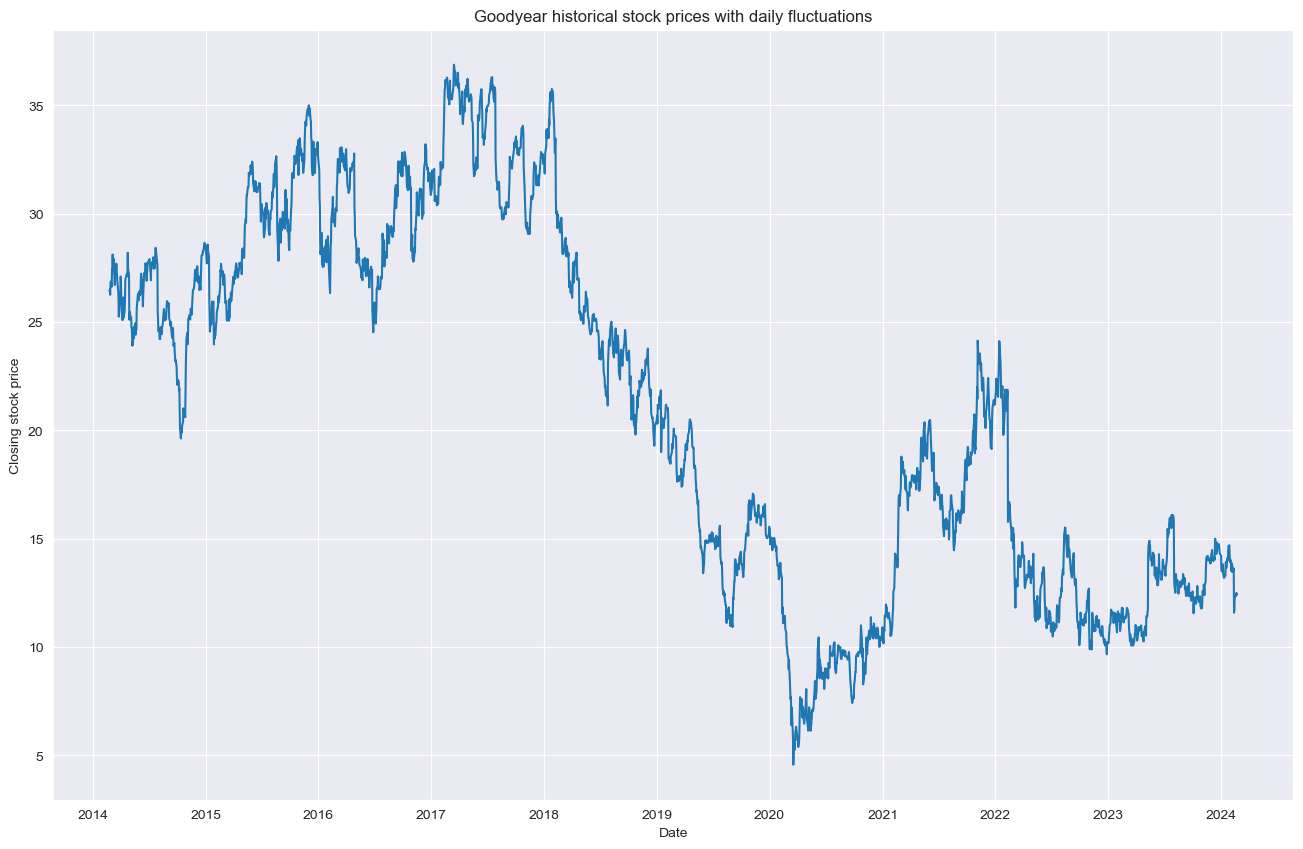

In [460]:
# overall impression of stock market performance over the years
plt.figure(figsize=(16,10))
sns.lineplot(x="date", y="GT",
             data=marketstack_filtered)

plt.ylabel('Closing stock price')
plt.xlabel('Date')
plt.title('Goodyear historical stock prices with daily fluctuations')

Text(0.5, 1.0, 'Goodyear historical stock prices on monthly frequency using asfreq()')

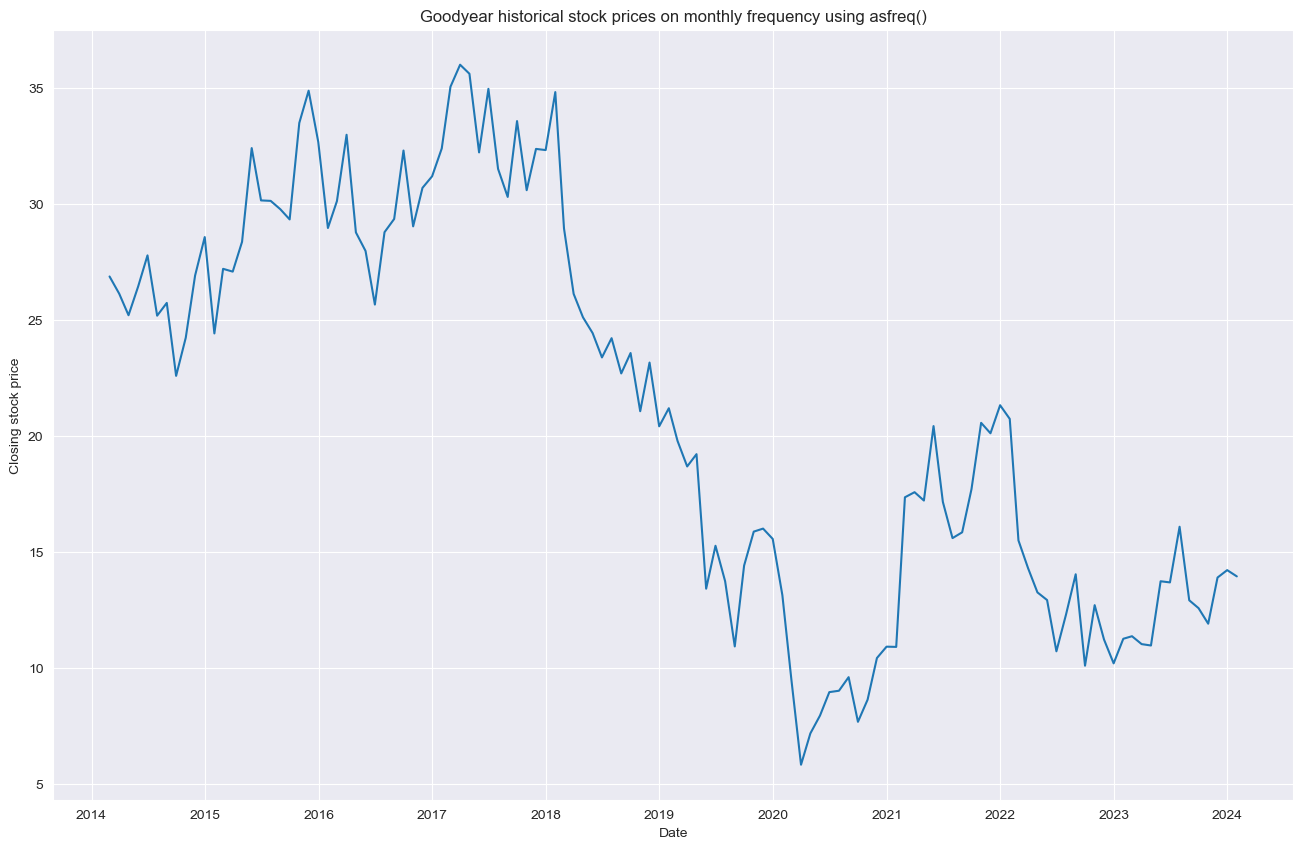

In [457]:
# overall impression of stock market performance over the years on monthly frequency
plt.figure(figsize=(16,10))
sns.lineplot(x="date", y="GT",
             data=marketstack_filtered.asfreq('ME', method='bfill'))

plt.ylabel('Closing stock price')
plt.xlabel('Date')
plt.title('Goodyear historical stock prices on monthly frequency using asfreq()')

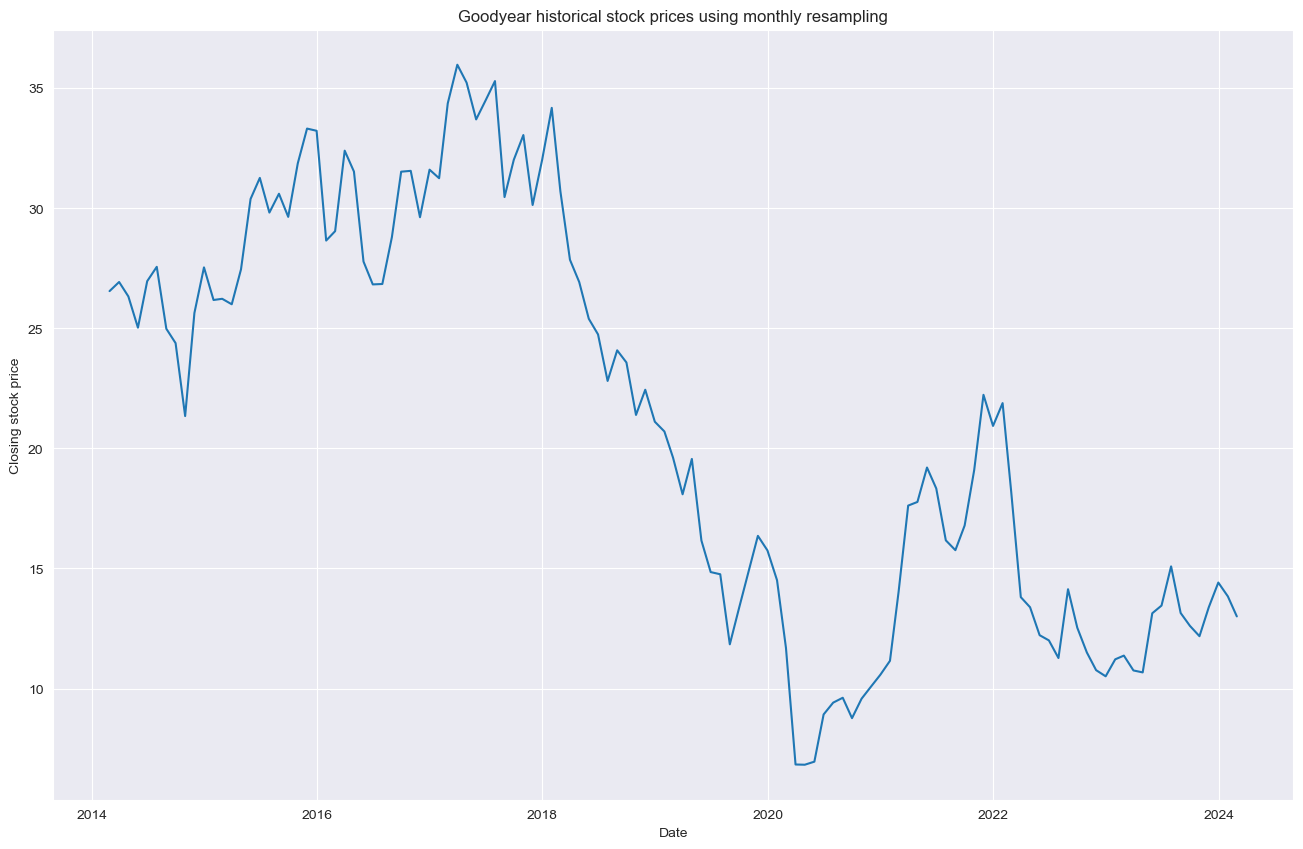

In [461]:
# Use resample instead of asfreq, how does it differ ?
freq = 'ME'
data = marketstack_filtered.resample(freq).mean().dropna()
plt.figure(figsize=(16,10))
sns.lineplot(x="date", 
             y="GT",
             data=data)

plt.ylabel('Closing stock price')
plt.xlabel('Date')
plt.title('Goodyear historical stock prices using monthly resampling')
plt.show()

>Resampled with aggregate mean gives a smoother cleaner result

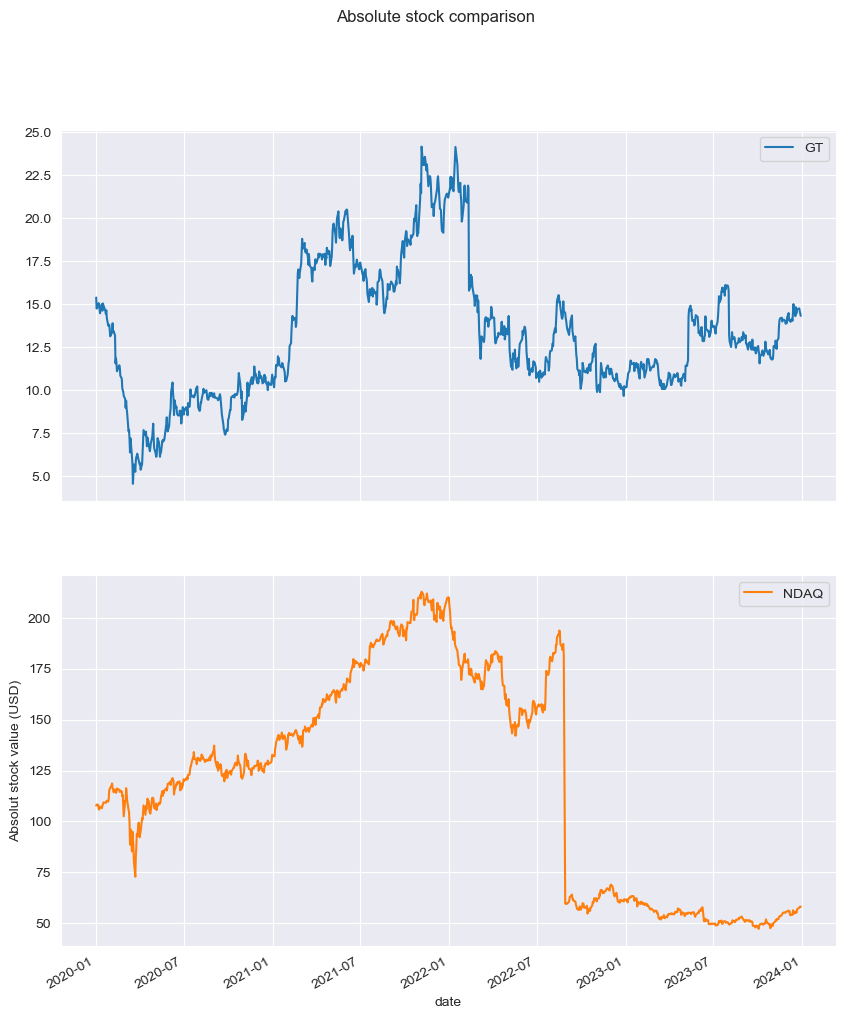

In [382]:
marketstack_filtered['2020':'2023'].plot(subplots=True, figsize=(10,12))
plt.suptitle('Absolute stock comparison')
plt.ylabel('Absolut stock value (USD)')
plt.show()

#### 1.2 Shifting and lags
We can shift index by desired number of periods with an optional time frequency. This is useful when comparing the time series with a past of itself

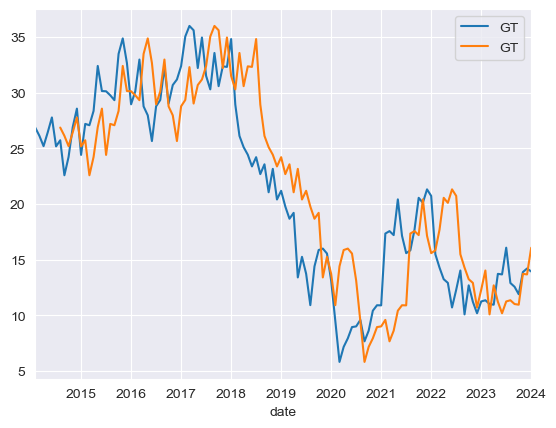

In [395]:
marketstack_filtered['GT'].asfreq('ME', method='bfill').plot(legend=True)
shifted = marketstack_filtered['GT'].asfreq('ME', method='bfill').shift(6).plot(legend=True)
shifted.legend(['GY','GY lagged by 6 months'])
plt.legend(bbox_to_anchor=(1,1))
plt.show()

## 2. Finance and Statistics

#### 2.1 Percent change
When we measure stock prices, we want to look at the trend of returns, meaning how stock prices changes from one day to the next

In [399]:
marketstack_pct = marketstack_filtered.pct_change(fill_method=None).dropna()

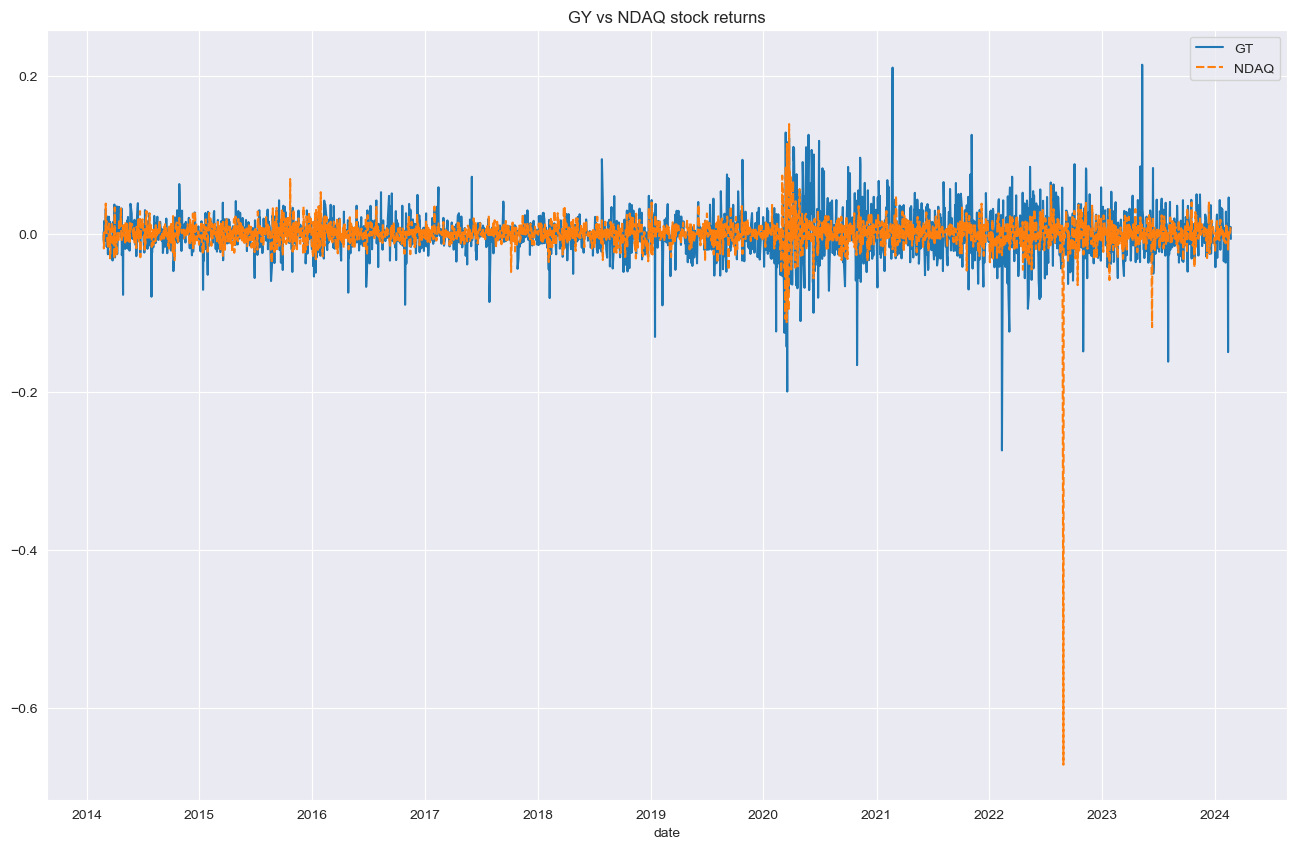

In [462]:
# calculate percentage change 
data = marketstack_filtered.pct_change(fill_method=None).dropna()
plt.figure(figsize=(16,10))
sns.lineplot(data=data)
plt.legend(bbox_to_anchor=(1,1))
plt.title('GY vs NDAQ stock returns')
plt.show()

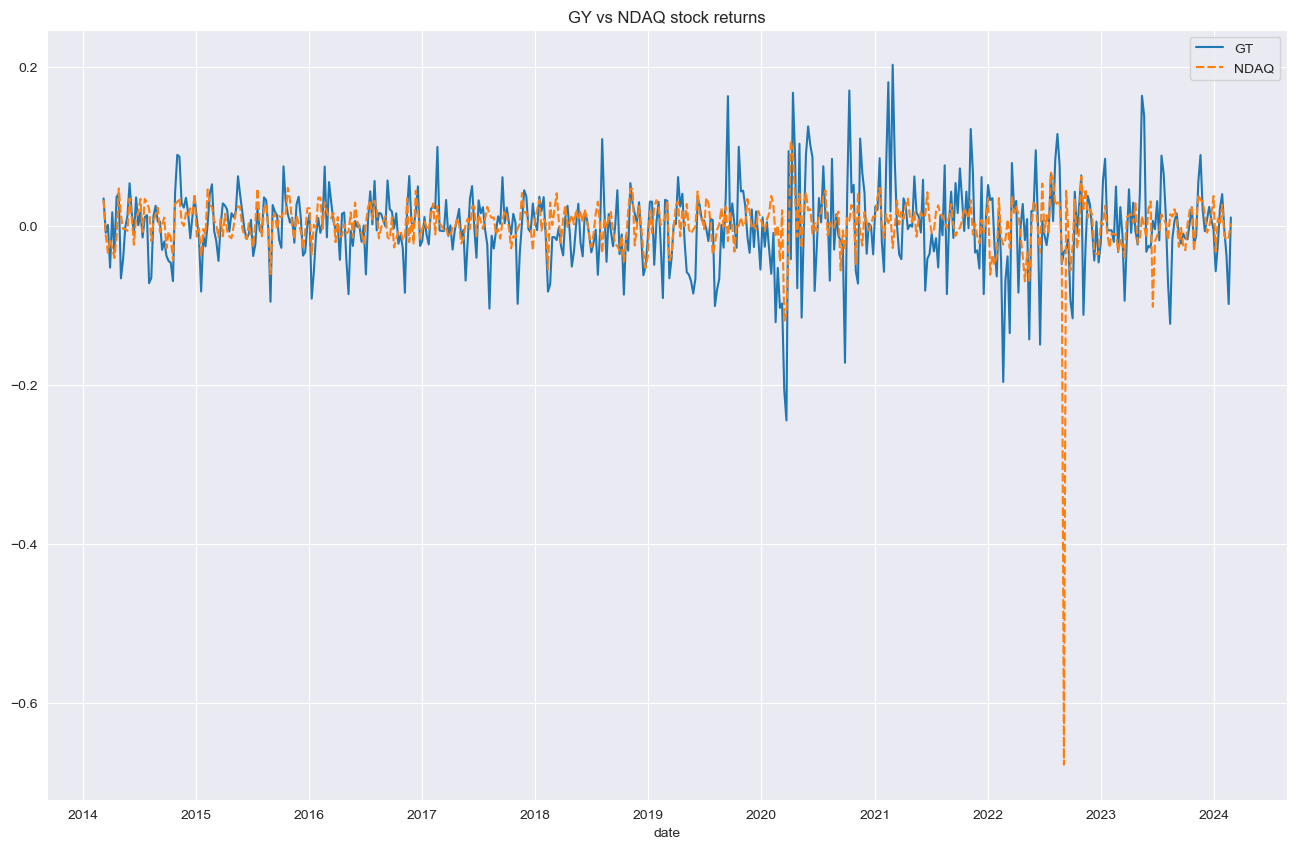

In [464]:
# calculate percentage change after resampling to weekly level
freq = 'W'
data = marketstack_filtered.resample(freq).mean()
data = data.pct_change(fill_method=None).dropna()
plt.figure(figsize=(16,10))
sns.lineplot(data=data)
plt.legend(bbox_to_anchor=(1,1))
plt.title('GY vs NDAQ stock returns')
plt.show()

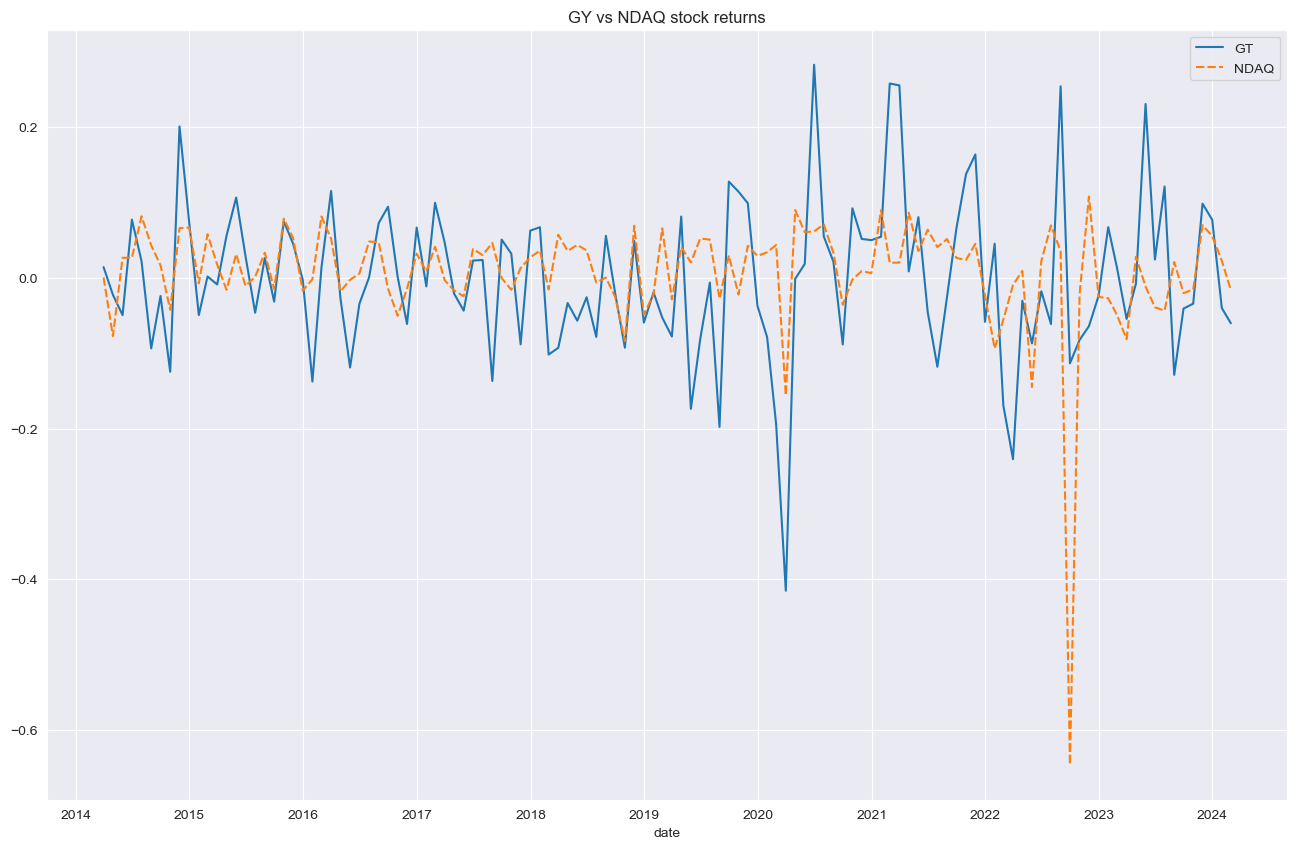

In [708]:
# calculate percentage change after resampling to weekly level
freq = 'ME'
data = marketstack_filtered.resample(freq).mean()
data = data.pct_change(fill_method=None).dropna()
plt.figure(figsize=(16,10))
sns.lineplot(data=data)
plt.legend(bbox_to_anchor=(1,1))
plt.title('GY vs NDAQ stock returns')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


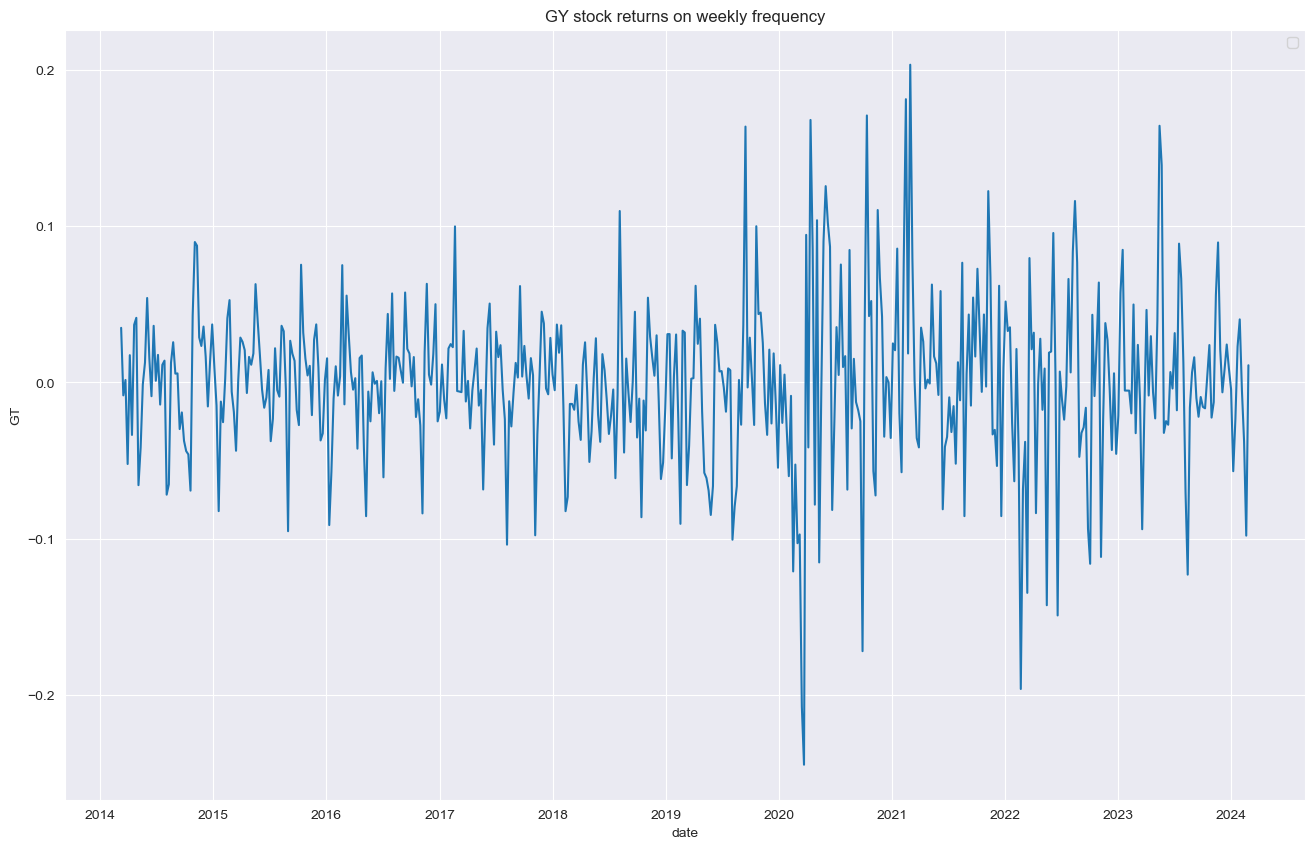

In [466]:
# calculate percentage change
plt.figure(figsize=(16,10))
sns.lineplot(data=data['GT'])
plt.legend(bbox_to_anchor=(1,1))
plt.title('GY stock returns on weekly frequency')
plt.show()

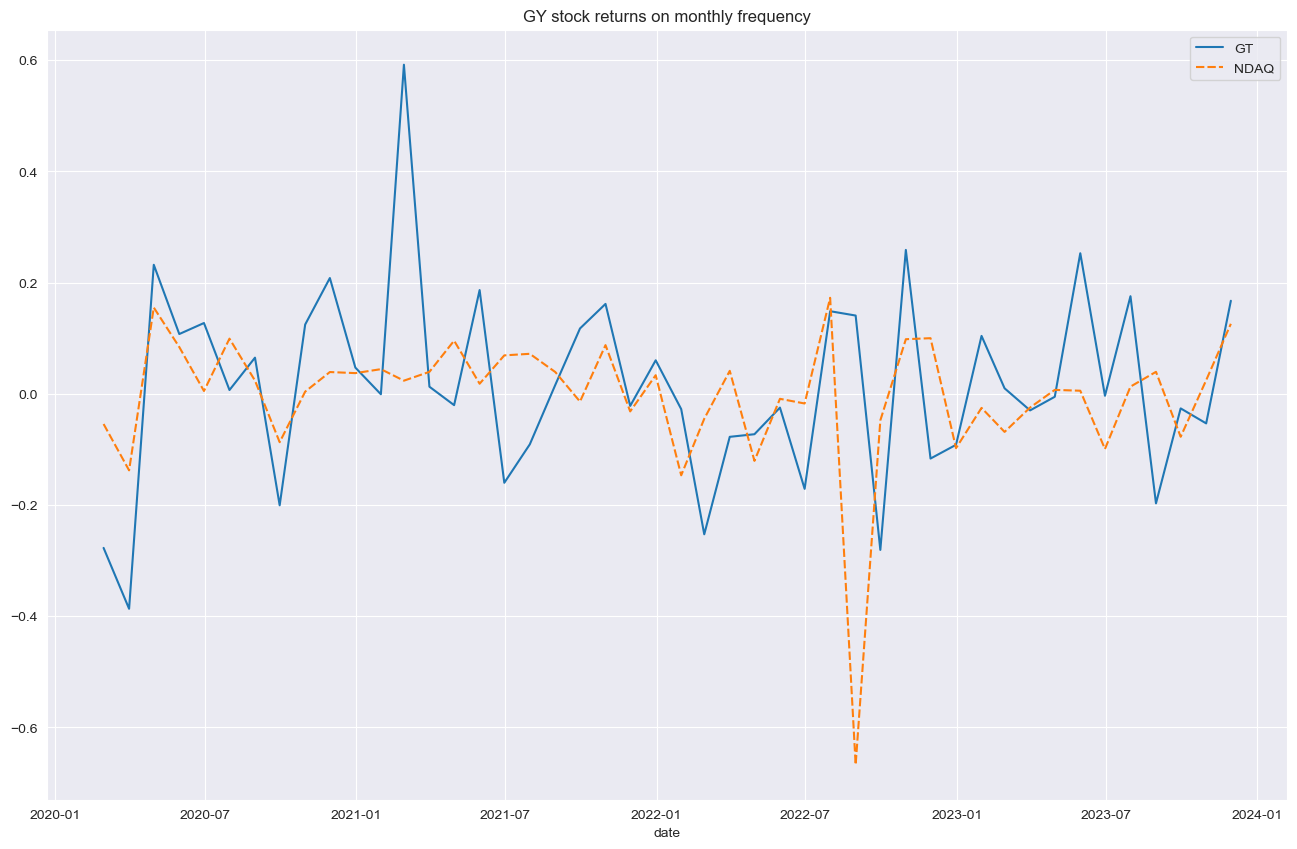

In [468]:
# calculate percentage change
data = marketstack_filtered['2020':'2023'].asfreq('ME', method='bfill').dropna()
plt.figure(figsize=(16,10))
sns.lineplot(data=data.pct_change())
plt.legend(bbox_to_anchor=(1,1))
plt.title('GY stock returns on monthly frequency')
plt.show()

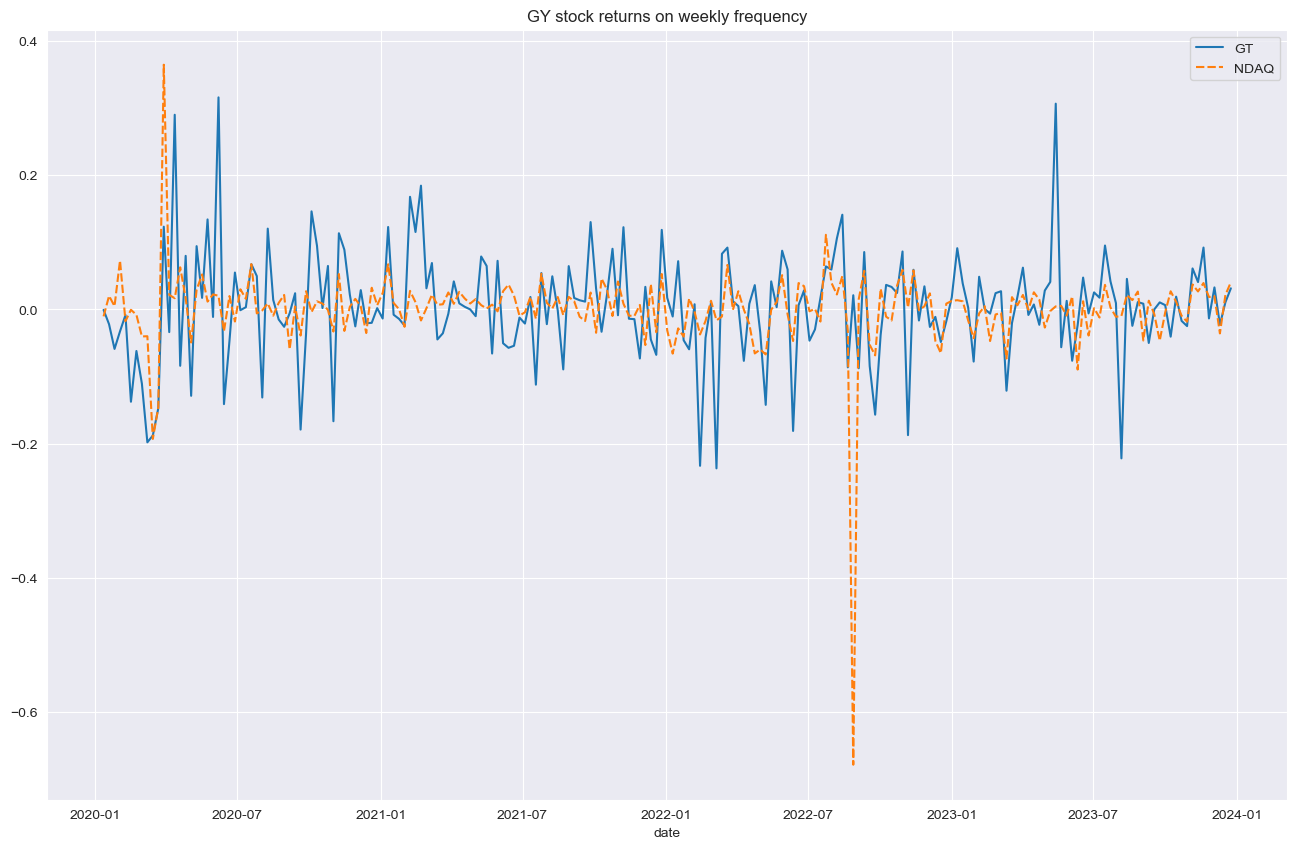

In [427]:
# calculate percentage change
data = marketstack_filtered['2020':'2023'].asfreq('W', method='bfill').dropna()
plt.figure(figsize=(16,10))
sns.lineplot(data=data.pct_change())
plt.legend(bbox_to_anchor=(1,1))
plt.title('GY stock returns on weekly frequency')
plt.show()

Correlation of stocks and interest rates:  0.0029390630654623244


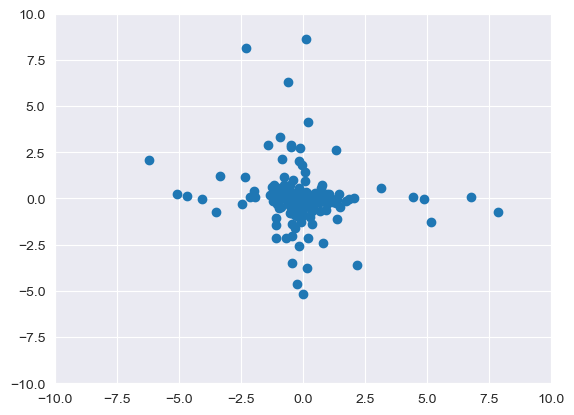

In [728]:
# Compute correlation between 2 stocks
returns = marketstack_filtered['2020':'2024'].rolling(30).mean()
returns = returns.resample('W').mean()
returns = returns.diff()
returns = returns.pct_change().dropna()
correlation = returns['GT'].corr(returns['NDAQ'])
plt.xlim(-10, 10)
plt.ylim(-10, 10)
print("Correlation of stocks and interest rates: ", correlation)

# Make scatter plot
plt.scatter(returns['GT'], returns['NDAQ'])
plt.show()

|#### 2.2 Absolute change in successive rows

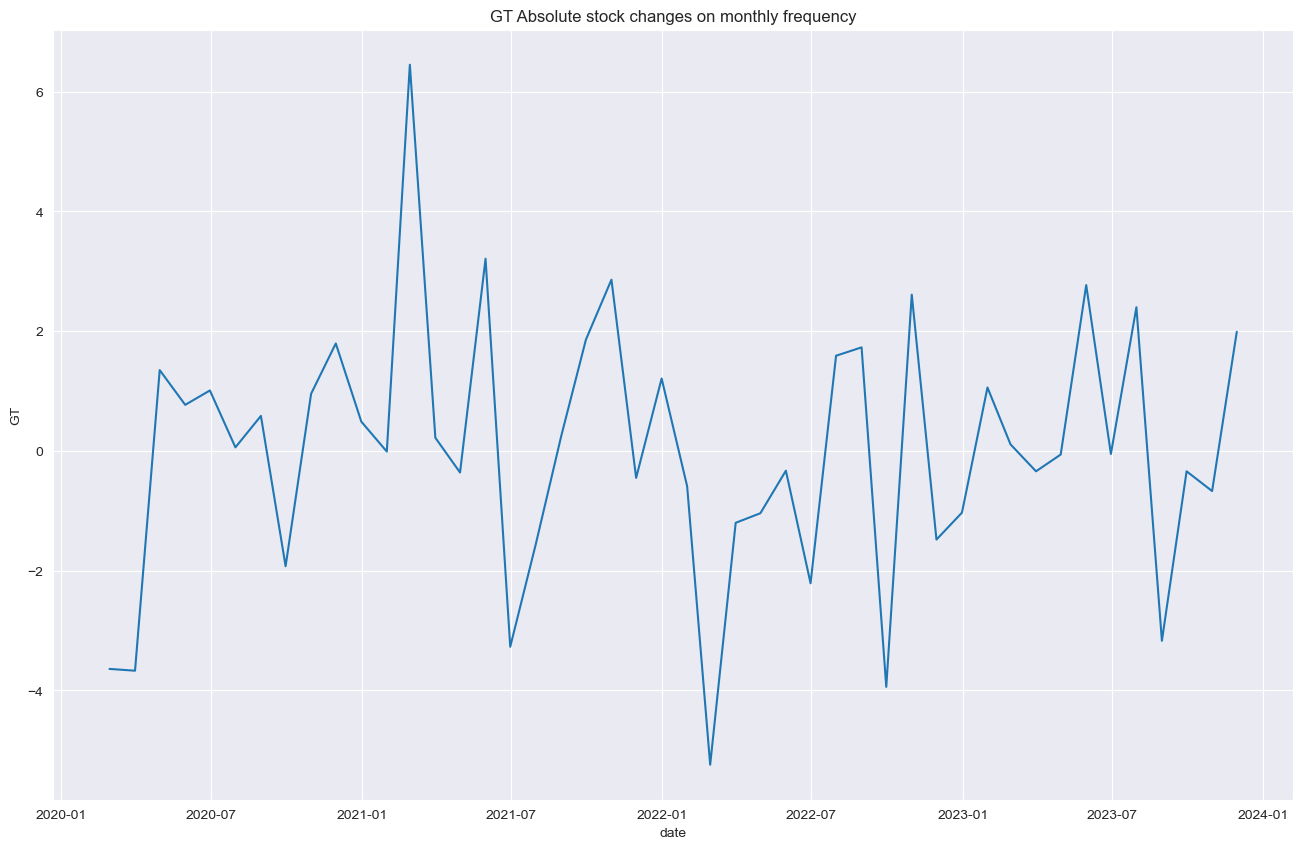

In [420]:
# calculate percentage change
data = marketstack_filtered['2020':'2023'].asfreq('ME', method='bfill').dropna()
plt.figure(figsize=(16,10))
sns.lineplot(data=data['GT'].diff())
# plt.legend(bbox_to_anchor=(1,1))
plt.title('GT Absolute stock changes on monthly frequency')
plt.show()

In [736]:
# Run regression over 2 stock markets

# Compute correlation between 2 stocks
returns = marketstack_filtered['2020':'2024'].rolling(30).mean()
returns = returns.resample('MS').mean()
returns = returns.pct_change().dropna()
correlation = returns['GT'].corr(returns['NDAQ'])
print("Correlation of stocks and interest rates: {}".format(correlation))

# Convert the Series x to a DataFrame and name the column x
dfx = pd.DataFrame(returns, columns=['GT'])

# Add a constant to the DataFrame dfx
dfx1 = sm.add_constant(dfx)

# Regress y on dfx1
result = sm.OLS(returns['NDAQ'],dfx1).fit()

# Print out the results and look at the relationship between R-squared and the correlation above
print(result.summary())


Correlation of stocks and interest rates: 0.31048665678683424
                            OLS Regression Results                            
Dep. Variable:                   NDAQ   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     4.908
Date:                Tue, 27 Feb 2024   Prob (F-statistic):             0.0317
Time:                        12:17:35   Log-Likelihood:                 46.775
No. Observations:                  48   AIC:                            -89.55
Df Residuals:                      46   BIC:                            -85.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

> R-squared is very low at 0.096, these 2 time series does not seem to be correlated

#### 2.3 Comaring two or more time series
We will compare 2 time series by normalizing them. This is achieved by dividing each time series element of all time series by the first element. This way both series start at the same point and can be easily compared.

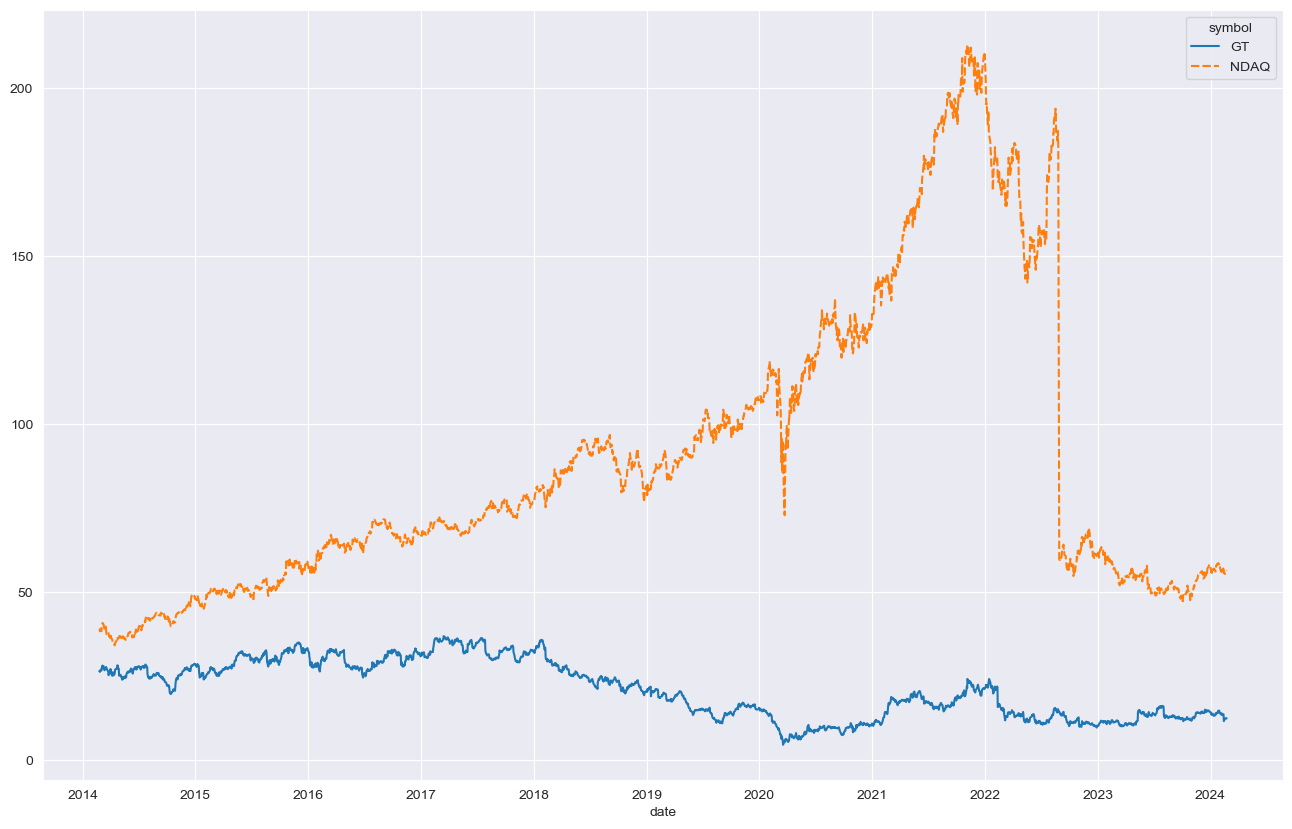

In [456]:
# Plotting before normalization
plt.figure(figsize=(16,10))
sns.lineplot(marketstack_filtered)
plt.show()

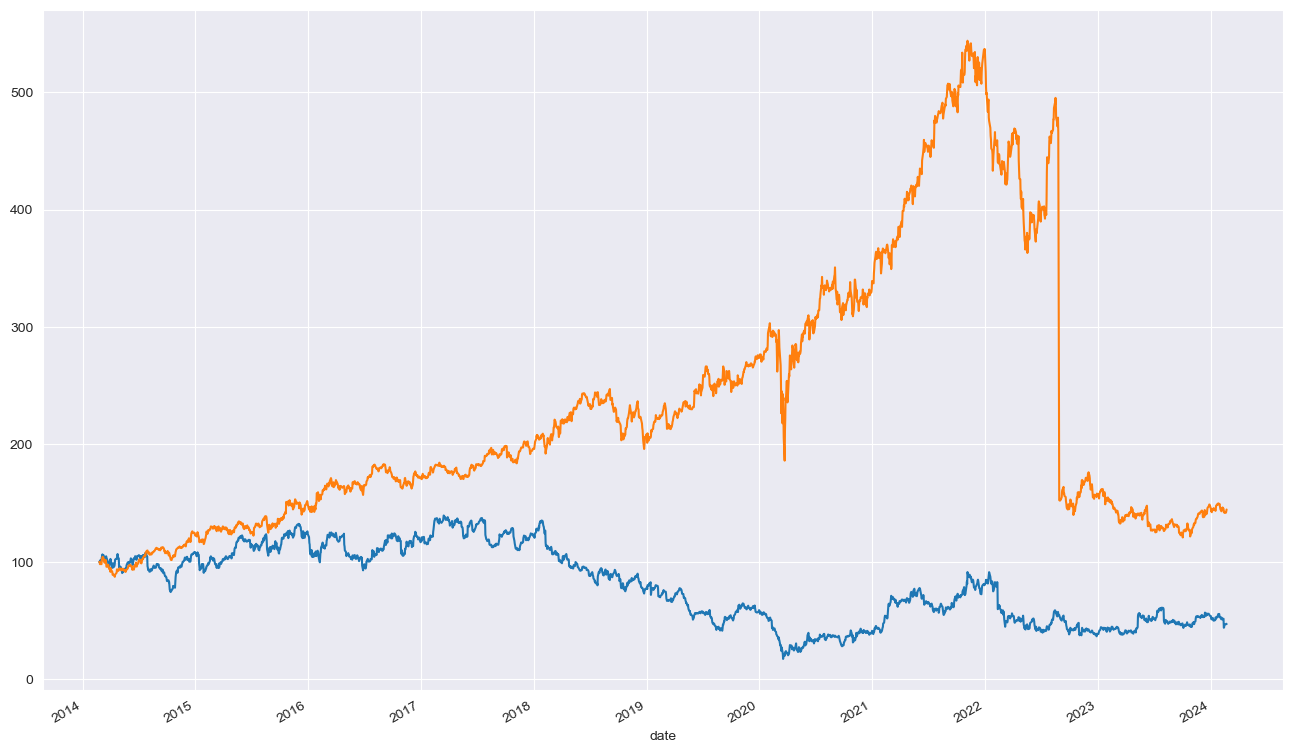

In [450]:
# Normalizing and comparison
# Both stocks start from 100
plt.figure(figsize=(16,10))
normalized_gy = marketstack_filtered['GT'].div(marketstack_filtered['GT'].iloc[0]).mul(100)
normalized_ndaq = marketstack_filtered['NDAQ'].div(marketstack_filtered['NDAQ'].iloc[0]).mul(100)
normalized_gy.plot()
normalized_ndaq.plot()
# plt.legend(['Google','Microsoft'])
plt.show()

#### 2.4 Moving average / Smoothing

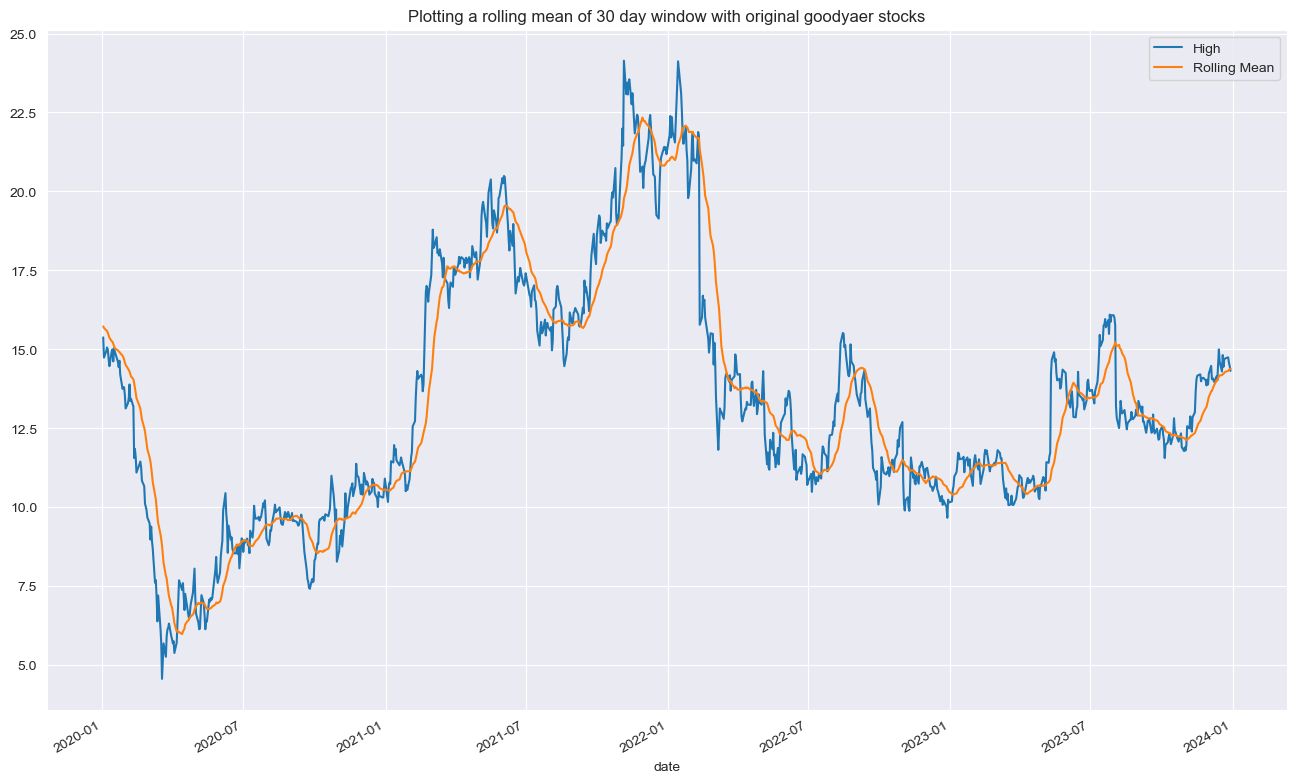

In [435]:
# Rolling window functions
plt.figure(figsize=(16,10))
rolling_gy = marketstack_filtered.rolling('30D').mean()
marketstack_filtered['2020':'2023']['GT'].plot()
rolling_gy['2020':'2023']['GT'].plot()
plt.legend(['High','Rolling Mean'])
plt.title('Plotting a rolling mean of 30 day window with original goodyaer stocks')
plt.show()

Now, observe that rolling mean plot is a smoother version of the original plot.

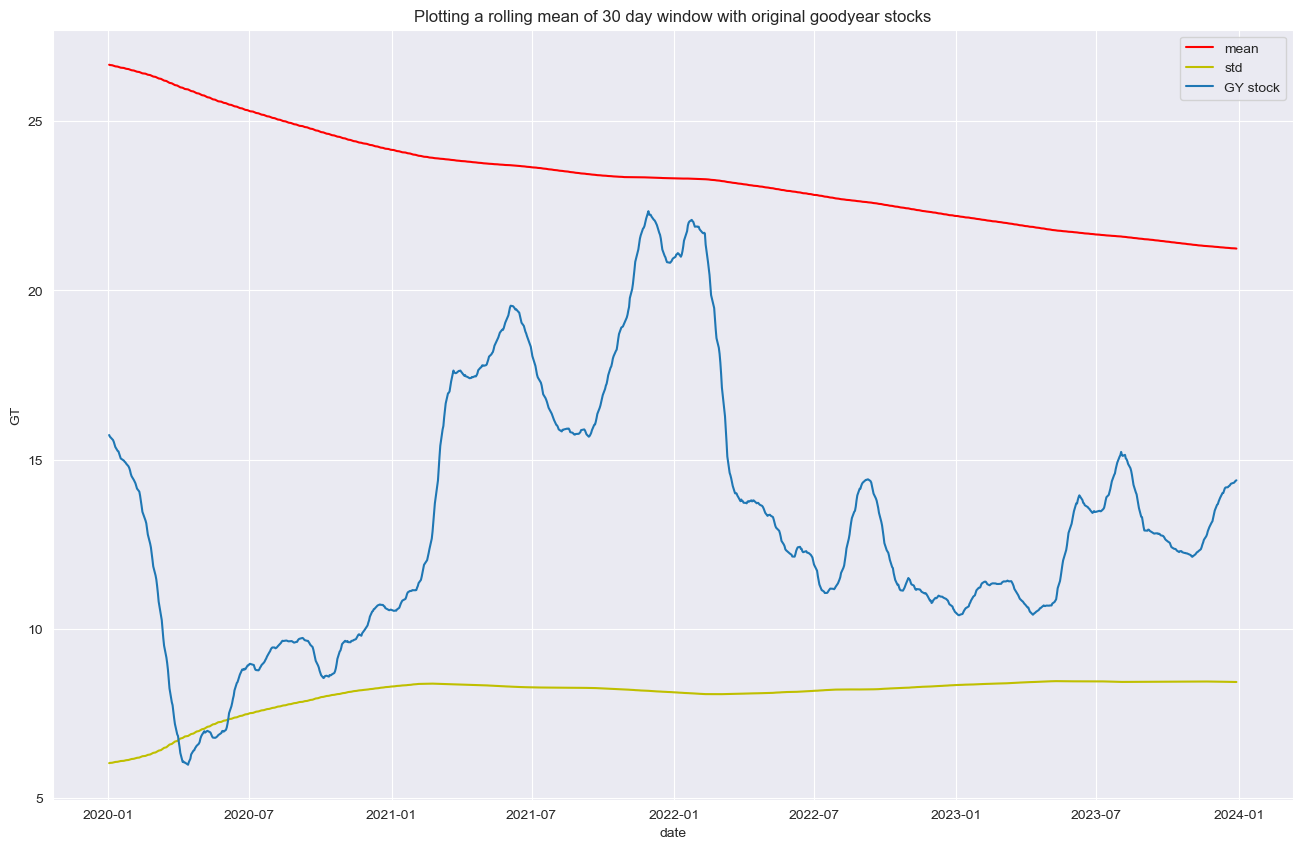

In [470]:
# expanding window functions (like an accumulative mean calculation)
plt.figure(figsize=(16,10))
gy_mean = marketstack_filtered['GT'].expanding().mean()
gy_std = marketstack_filtered['GT'].expanding().std()
sns.lineplot(gy_mean['2020':'2023'], label='mean', color='r')
sns.lineplot(gy_std['2020':'2023'], label='std', color='y')
sns.lineplot(rolling_gy['2020':'2023']['GT'], label='GY stock')
plt.legend()
plt.title('Plotting a rolling mean of 30 day window with original goodyear stocks')
plt.show()

In [510]:
# Build enhanced smoothed dataset showing returns
# Remove noice from daily fluctuations by calculating a day 30 moving average

# calculate a rolling 30 day moving average to get rid of noice
marketstack_ma = marketstack_filtered.rolling('30D').mean()

# resample to monthly level
freq='ME'
marketstack_month = marketstack_ma.resample(freq).mean()

# calculate percentage changes
marketstack_pct = marketstack_month.pct_change().dropna()
marketstack_pct.head()

symbol,GT,NDAQ
date,,
2014-03-31,0.020571,0.005176
2014-04-30,-0.022428,-0.058500
2014-05-31,-0.028987,-0.016202
2014-06-30,0.015474,0.026140
2014-07-31,0.054953,0.049590


In [511]:
marketstack_ma 

symbol,GT,NDAQ
date,,
2014-02-24,26.440000,39.120000
2014-02-25,26.470000,39.095000
2014-02-26,26.400000,38.846667
2014-02-27,26.472500,38.740000
2014-02-28,26.552000,38.670000
...,...,...
2024-02-15,13.679091,57.171818
2024-02-16,13.607727,57.140455
2024-02-20,13.532381,57.045238


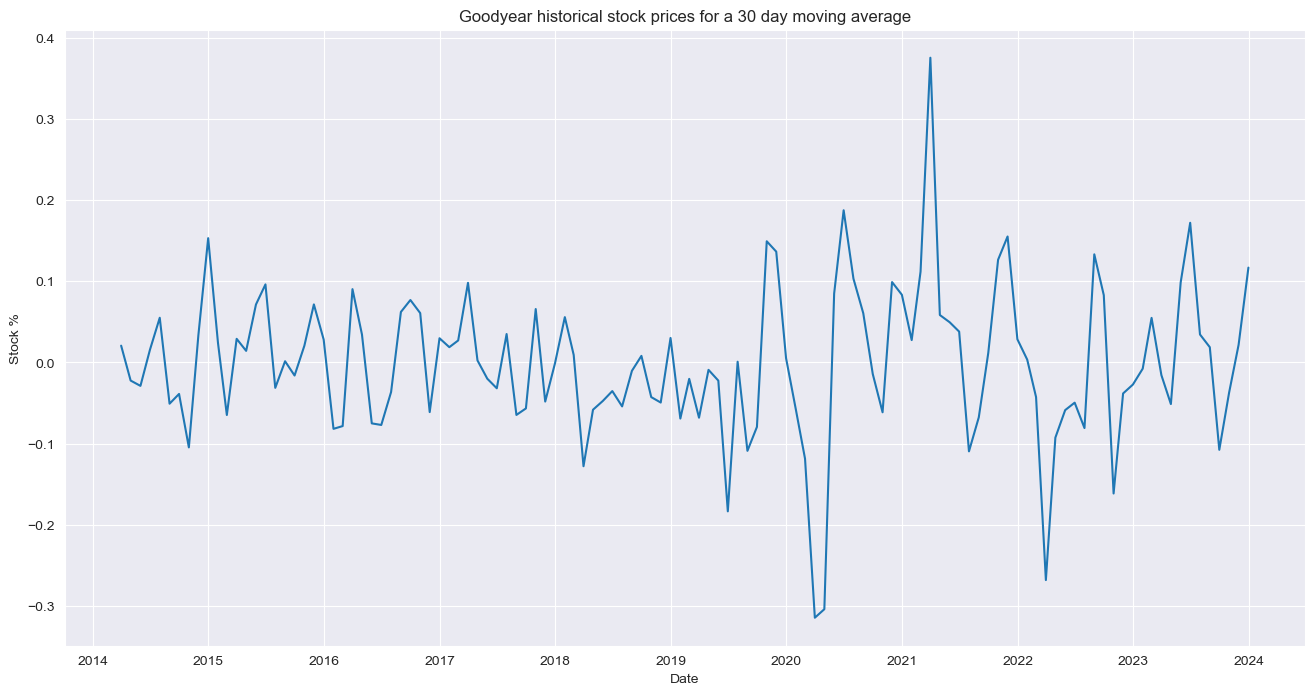

In [512]:

returns = marketstack_pct['2014':'2023']
plt.figure(figsize=(16,8))
sns.lineplot(
    x=returns.index,
    y=returns['GT'])
    # hue=data.index.year,
    # palett='viridis_r')

plt.ylabel('Stock %')
plt.xlabel('Date')
plt.title('Goodyear historical stock prices for a 30 day moving average')
plt.show()

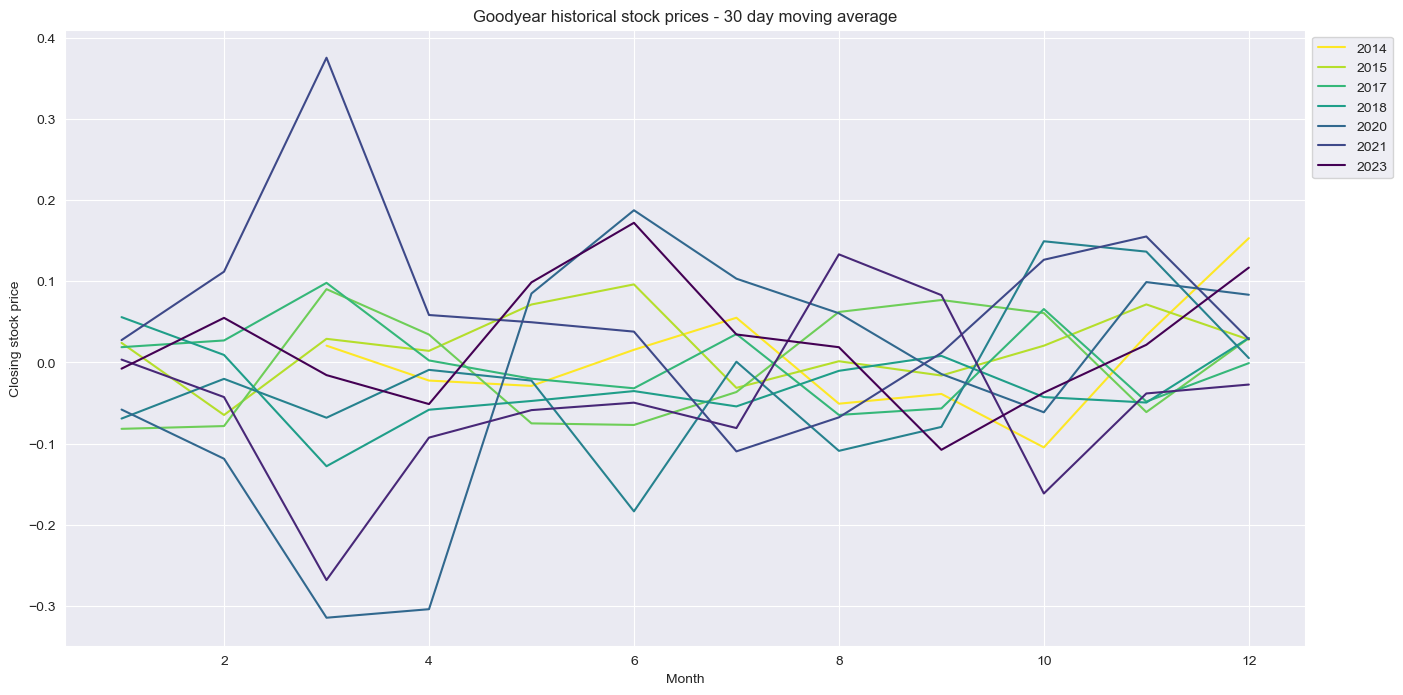

In [513]:
# plot the timeseries data
plt.figure(figsize=(16,8))
sns.lineplot(
    x=returns.index.month, 
    y=returns.GT,
    hue=returns.index.year,
    palette='viridis_r')

plt.ylabel('Closing stock price')
plt.xlabel('Month')
plt.title('Goodyear historical stock prices - 30 day moving average')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

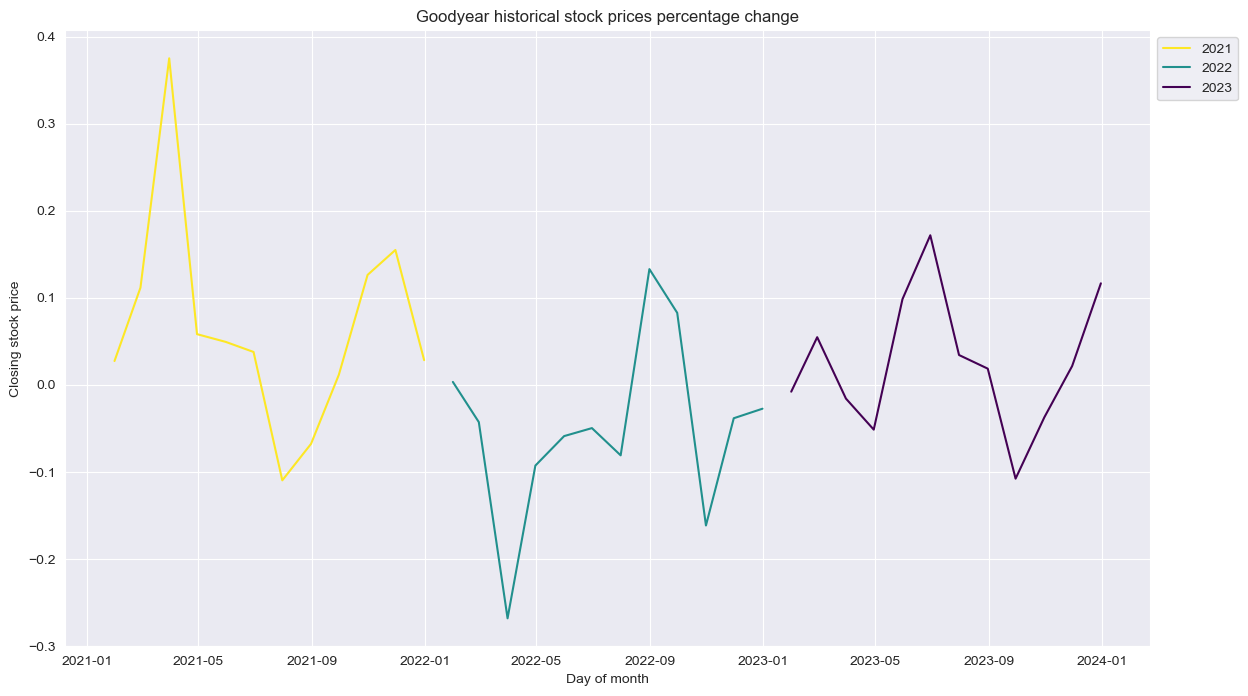

In [514]:
# Change frequency to month and calculate percentage change
data = returns['2021':'2024']
plt.figure(figsize=(14,8))
sns.lineplot(
    x=data.index, 
    y=data['GT'],
    hue=data.index.year,
    palette='viridis_r')

plt.ylabel('Closing stock price')
plt.xlabel('Day of month')
plt.title('Goodyear historical stock prices percentage change')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

## ARIMA analysis

# Step 1. dickley fuller test - Is the time series a random walk ?
dickey fuller helps us to see if our time series is a random walk or not. If pvalue is < 5% it is not random walk and we can use it for forecasting without any transformations. If pvalue > 5%, we have to convert the time series to make it stationary first, with other .diff() or .pct_change(), however ARIMA works with diff best.

## Random walk with drift

In general if we talk about stocks, Today's Price = Yesterday's Price + Noise

Pt = Pt-1 + εt
Random walks can't be forecasted because well, noise is random.

Random Walk with Drift(drift(μ) is zero-mean)

Pt - Pt-1 = μ + εt

Regression test for random walk

Pt = α + βPt-1 + εt
Equivalent to Pt - Pt-1 = α + βPt-1 + εt

Test:

H0: β = 1 (This is a random walk)
H1: β < 1 (This is not a random walk)

Dickey-Fuller Test:

H0: β = 0 (This is a random walk)
H1: β < 0 (This is not a random walk)

In a random walk with drift, prices on average drift by mu every period. And the change in price for a random walk with drift is still white noise but with a mean of mu. So if we now think of stock prices as a random walk with drift, then the returns are still white noise, but with an average return of mu instead of zero.

To test whether a series like stock prices follows a random walk, you can regress current prices on lagged prices. If the slope coefficient, beta, is not significantly different from one, then we cannot reject the null hypothesis that the series is a random walk. However, if the slope coefficient is significantly less than one, then we can reject the null hypothesis that the series is a random walk.

**Statistical Test for Random Walk**
An identical way to do that test is to regress the difference in prices on the lagged price, and instead of testing whether the slope coefficient is 1, now we test whether it is zero.

This is called the "Dickey-Fuller" test. If you add more lagged prices on the right hand side, then it's called the Augmented Dickey-Fuller test.



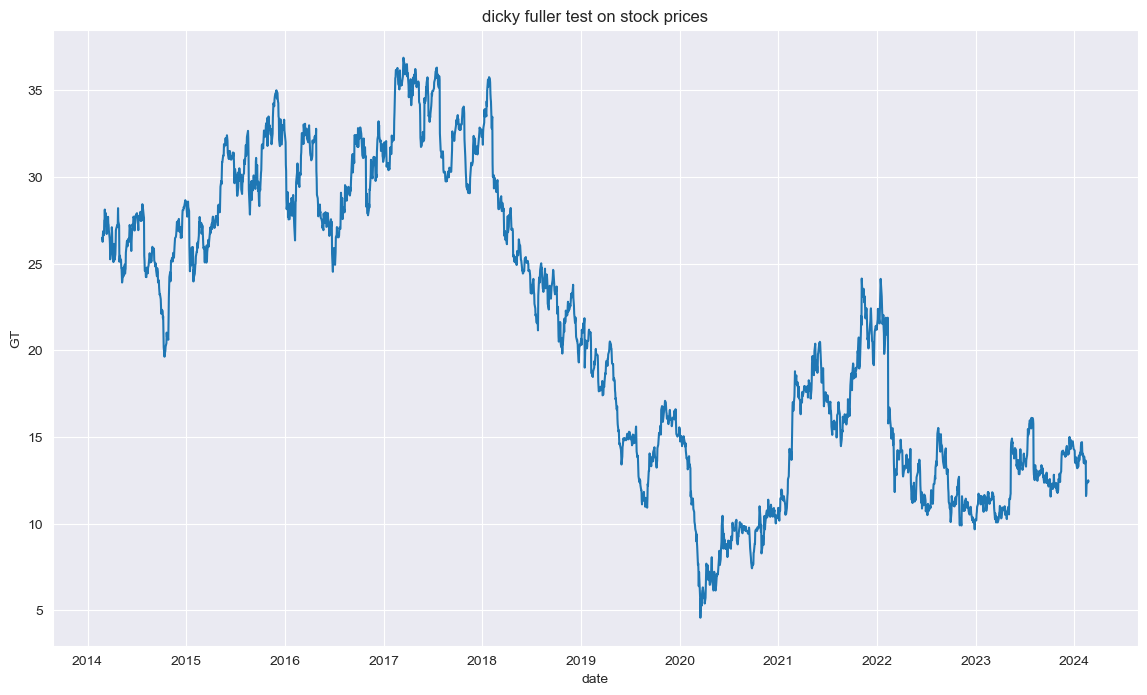


The p-value of the test on prices is: 0.5840460000616758


In [631]:
# Run adfuller test on the daily stock price data without any data transformations
plt.figure(figsize=(14,8))
sns.lineplot(marketstack_filtered['GT'])
plt.title('Dickey-Fuller test on stock prices')
plt.show()

results = adfuller(marketstack_filtered['GT'])
print('\nThe p-value of the test on prices is: ' + str(results[1]))

> GY stock prices without transformation is a random walk with trends, and cannot be used for forecasting directly when using ARIMA.

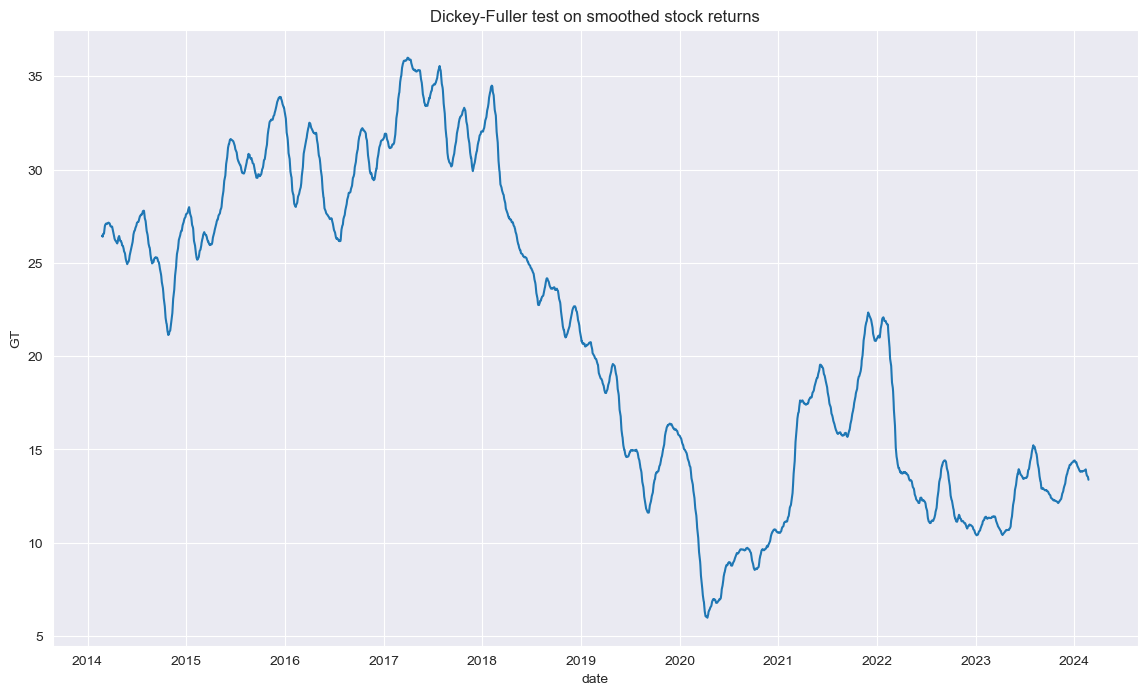


The p-value of the test on prices is: 0.5727193161496704


In [684]:
# Run adfuller test on daily stock price which is smoothed with a 30 day rolling moving average
plt.figure(figsize=(14,8))
sns.lineplot(marketstack_ma['GT'])
plt.title('Dickey-Fuller test on smoothed stock returns')
plt.show()

results = adfuller(marketstack_ma['GT'])
# print(results)

# Just print out the p-value
print('\nThe p-value of the test on prices is: ' + str(results[1]))

> If the p-value is less than 5%, we can reject the null hypothesis that the series is a random walk with 95% confidence. This is good news it means we can use the time series to forecast future results

# Step 2: Stationarity
If a time series is a random walk, convert it into stationary dataset first before we can do any forecasting when using the ARIMA model.

**What means Stationarity?**
It means that the joint distribution of the observations do not depend on time. It has no trend and autocorration is constant.

A less restrictive version of stationarity, and one that is easier to test, is weak stationarity, which just means that the mean, variance, and autocorrelations of the observations do not depend on time. In other words, for the autocorrelation, the correlation between X-t and X-(t-tau) is only a function of the lag tau, and not a function of time.

If a process is not stationary, then it becomes difficult to model. Modeling involves estimating a set of parameters, and if a process is not stationary, and the parameters are different at each point in time, then there are too many parameters to estimate. You may end up having more parameters than actual data! So stationarity is necessary for a parsimonious model, one with a smaller set of parameters to estimate.

diff() method can easily convert a non-stationary series to a stationary series.

In [685]:
# first lets transform timeseries into month instead of daily periods using month start as timestamp.
freq = 'MS'
marketstack_ma_month = marketstack_ma.resample(freq).mean()

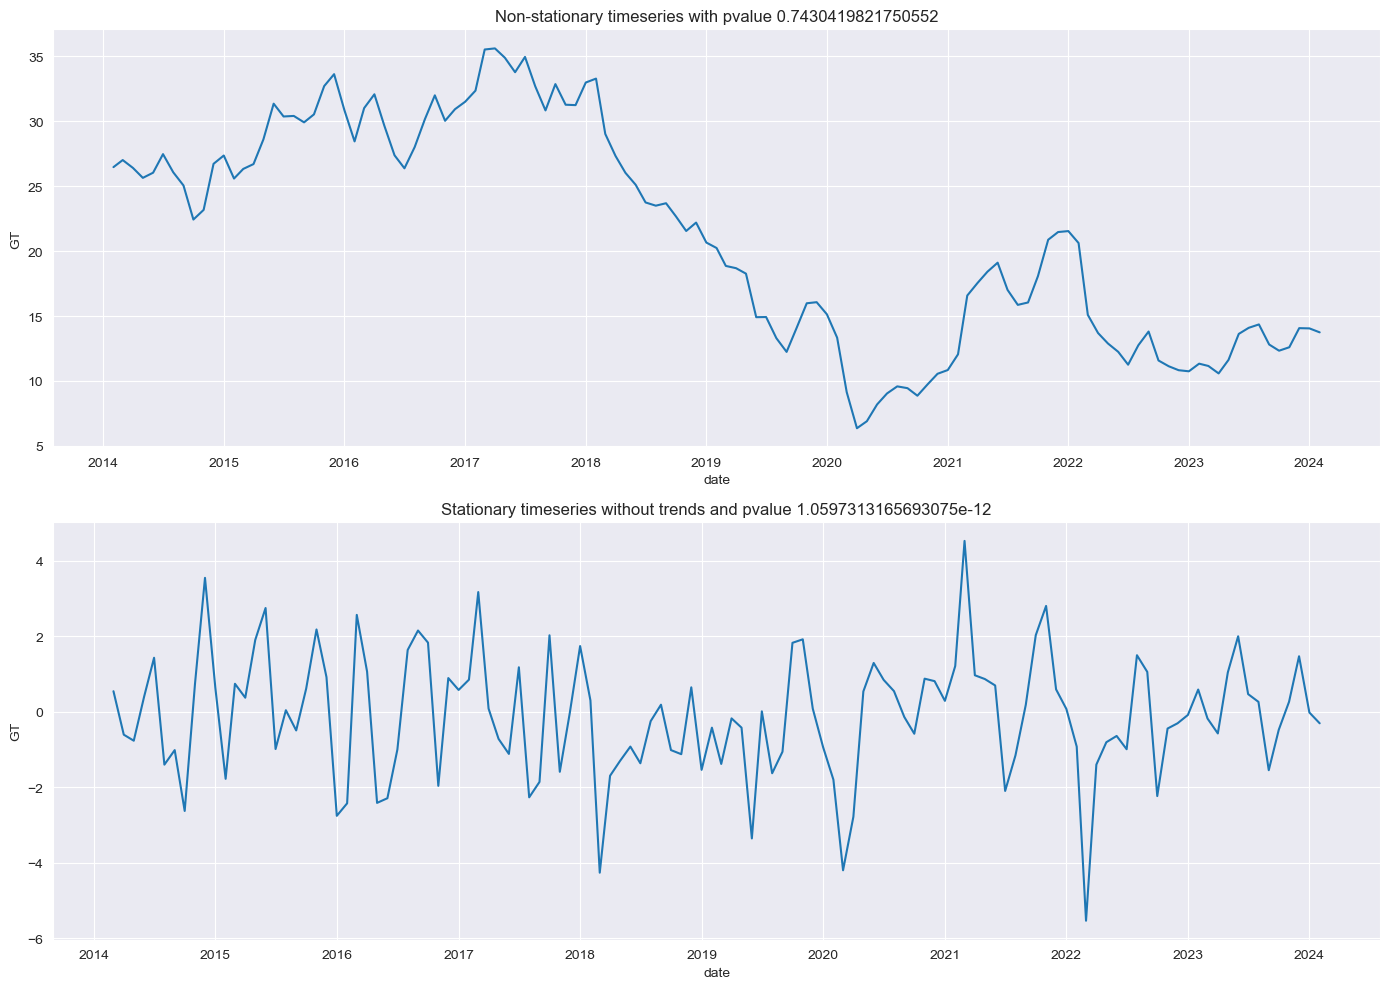

In [693]:
# example on non-stationary plot, time influence the stock prices, example pre and post covid
fig, axes = plt.subplots(2,1, figsize=(14,10))

ax1 = sns.lineplot(data=marketstack_ma_month['GT'], ax=axes[0])
results = adfuller(marketstack_ma_month['GT'])
ax1.title.set_text('Non-stationary timeseries with pvalue {}'.format(results[1]))

marketstack_diff = marketstack_ma_month.diff().dropna()
ax2 = sns.lineplot(marketstack_diff['GT'], ax=axes[1])
results = adfuller(marketstack_diff['GT'])
ax2.title.set_text('Stationary timeseries without trends and pvalue {}'.format(results[1]))
plt.tight_layout()

>By seasonally adjusting the series, we eliminated the seasonal pattern in the autocorrelation function.

# Step 3: Compute ACF and PACF
To identify the ARIMA model parameters, we use ACF and PACF to help us select hyper parameters for RA or MA order.
Series must be stationary **before** we use ACF and PACF


Now that the time series is stationary, compute the sample ACF and PACF. This will provide some guidance on the order of the ARIMA model to use.

## Autocorrelation
The autocorrelation function (ACF) measures how a series is correlated with itself at different lags.

Autocorrelation is the correlation of a single time series with a lagged copy of itself. It's also called "serial correlation". Often, when we refer to a series's autocorrelation, we mean the "lag-one" autocorrelation. So when using daily data, for example, the autocorrelation would be the correlation of the series with the same series lagged by one day.

When you look at the correlation of say, two stocks, you should look at the correlation of their *returns*, not their levels, it makes them more comparable.

What does it mean when a series has a positive or negative autocorrelation? 
- With financial time series, when returns have a negative autocorrelation, we say it is "mean reverting". Mean reversion is a financial theory which suggests that, after an extreme price move, asset prices tend to return back to normal or average levels.
- If a series has positive autocorrelation, we say it is "trend-following".

Many hedge fund strategies are only slightly more complex versions of mean reversion and momentum strategies. Since stocks have historically had negative autocorrelation over horizons of about a week, one popular strategy is to buy stocks that have dropped over the last week and sell stocks that have gone up. For other assets like commodities and currencies, they have historically had positive autocorrelation over horizons of several months, so the typical hedge fund strategy there is to buy commodities that have gone up in the last several months and sell those commodities that have gone down.

In [738]:
# plotting auto correlations using pct over a 30 day average

# daily correlation
pct_daily = marketstack_ma.pct_change().dropna()
autocorrelation = pct_daily['GT'].autocorr()
print('GT daily correlation: {}'.format(autocorrelation))

# weekly correlation
rates_weekly = marketstack_ma['GT'].resample(rule='W').mean()
pct_weekly = rates_weekly.pct_change().dropna()
autocorrelation = pct_weekly.autocorr()
print("GT weekly correlation %4.2f" %(autocorrelation))

# monthly correlation
rates_monthly = marketstack_ma['GT'].resample(rule='ME').mean()
pct_monthly = rates_monthly.pct_change().dropna()
autocorrelation = pct_monthly.autocorr()
print("GT monthly correlation %4.2f" %(autocorrelation))

# quarterly correlation
rates_quarterly = marketstack_ma['GT'].resample(rule='QE').mean()
pct_quarterly = rates_quarterly.pct_change().dropna()
autocorrelation = pct_quarterly.autocorr()
print("GT quarterly correlation %4.2f" %(autocorrelation))

# yearly correlation
rates_yearly = marketstack_ma['GT'].resample(rule='YE').mean()
pct_yearly= rates_yearly.pct_change().dropna()
autocorrelation = pct_yearly.autocorr()
print("GT yearly correlation %4.2f" %(autocorrelation))


GT daily correlation: 0.7855543757784518
GT weekly correlation 0.84
GT monthly correlation 0.37
GT quarterly correlation 0.09
GT yearly correlation -0.25


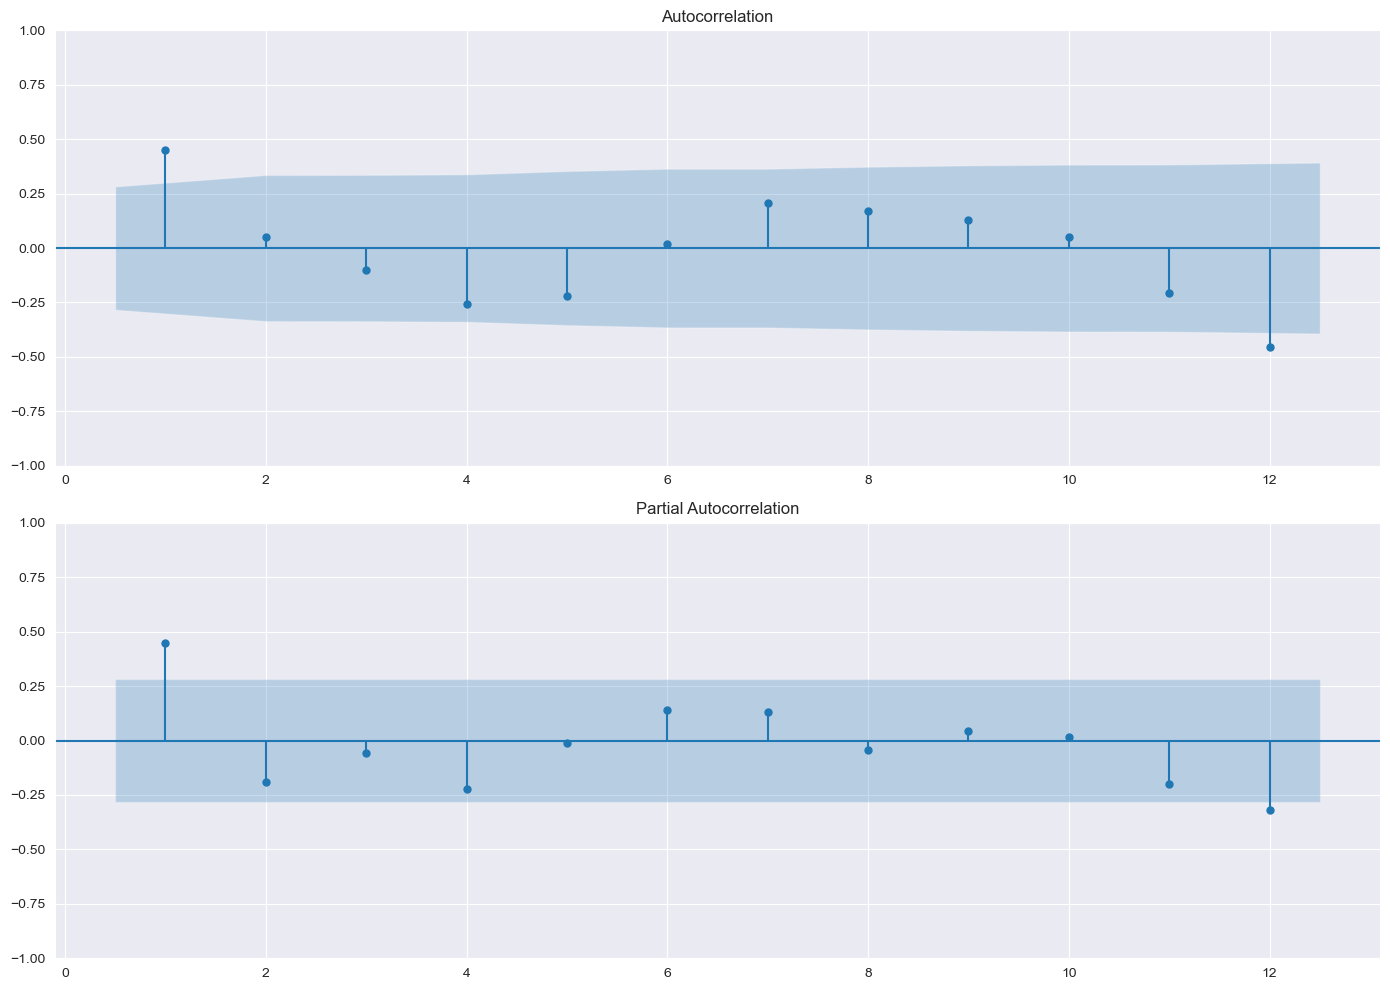

In [702]:
# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1, figsize=(14,10))

# Plot the ACF
tsaplots.plot_acf(marketstack_diff['2020': '2023']['GT'], 
                  lags=12, 
                  zero=False, 
                  alpha=0.05, 
                  ax=axes[0])

# Plot the PACF
tsaplots.plot_pacf(marketstack_diff['2020': '2023']['GT'], 
                  lags=12, 
                  zero=False, 
                  alpha=0.05, 
                  ax=axes[1])
plt.tight_layout()

#### PLOT_AFC
The sample autocorrelation function, or ACF,shows not only the lag-one autocorrelation from the last chapter, but the entire autocorrelation function for different lags. Any significant non-zero autocorrelations implies that the series can be forecast from the past.

In plot_acf, the argument alpha determines the width of the confidence intervals. For example, if alpha equals 0.05, that means that if the true autocorrelation at that lag is zero, there is only a 5% chance the sample autocorrelation will fall outside that window. You will get a wider confidence interval if you set alpha lower, or if you have fewer observations. An approximation to the width of the 95% confidence intervals, if you make some simplifying assumptions, is plus or minus 2 over the square root of the number of observations in your series. Incidentally, if you don't want to see confidence intervals in your plot, set alpha equal to one.



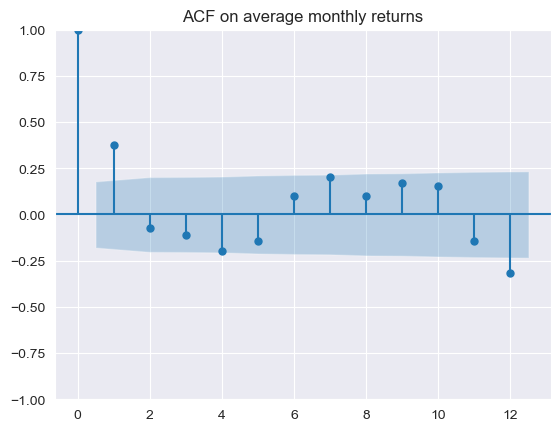

In [536]:
# 'acf' is an abbreviation for auto correlation function
tsaplots.plot_acf(pct_monthly, 
                  zero=False, 
                  lags=12,
                  alpha=0.05)
plt.title('ACF on average monthly returns')
plt.show()

> Lag 1 and 12 can be used to forcast the time series on monthly level

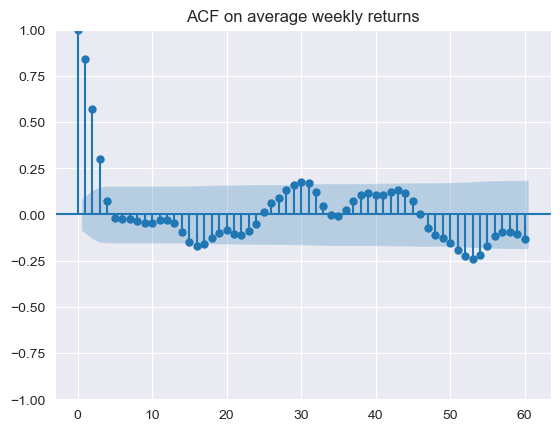

In [545]:
tsaplots.plot_acf(pct_weekly, 
                  zero=False, 
                  lags=60, 
                  alpha=0.05)
plt.title('ACF on average weekly returns')
plt.show()

> Lag 1-3, 51 52 can be used to forcast the time series on weekly level


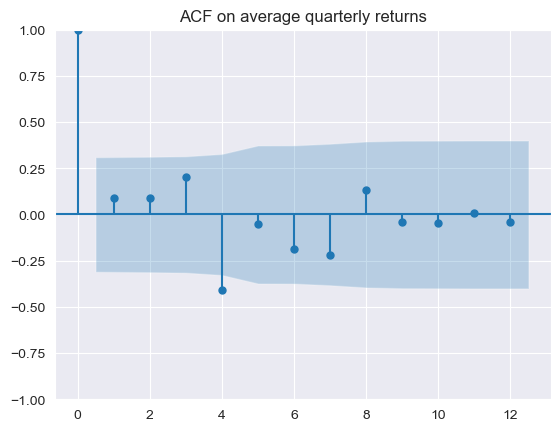

In [544]:
tsaplots.plot_acf(pct_quarterly, 
                  zero=False, 
                  lags=12, 
                  alpha=0.05)
plt.title('ACF on average quarterly returns')
plt.show()

> Lag 4 can be used to forcast the time series on quarterly level


## Partial Autocorrelation
The partial autocorrelation function can be interpreted as a regression of the series against its past lags. The terms can be interpreted the same way as a standard linear regression, that is the contribution of a change in that particular lag while holding others constant.


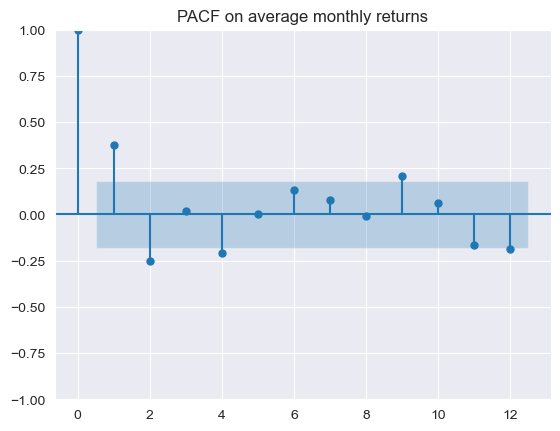

In [547]:
# plotting partial auto correlation function (pacf)
tsaplots.plot_pacf(pct_monthly, lags=12, method='ywm', alpha=0.05)
plt.title('PACF on average monthly returns')
plt.show()

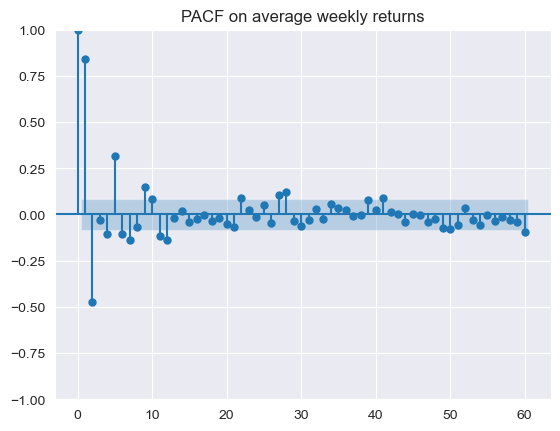

In [548]:
tsaplots.plot_pacf(pct_weekly, lags=60, alpha=0.05)
plt.title('PACF on average weekly returns')
plt.show()

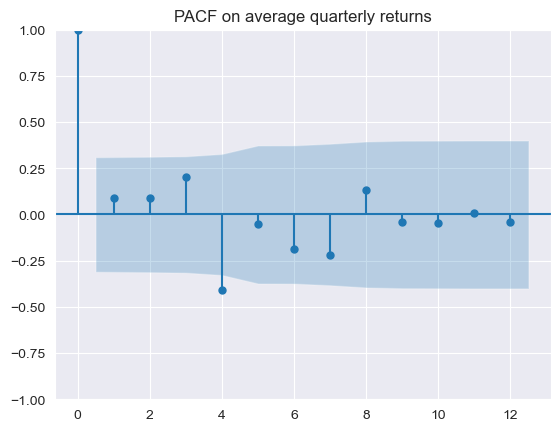

In [549]:
tsaplots.plot_acf(pct_quarterly, lags=12, alpha=0.05)
plt.title('PACF on average quarterly returns')
plt.show()

#### White noice

White noise has...
- Constant mean
- Constant variance
- Zero auto-correlation at all lags

Can't Forecast White Noise
A white noise time series is simply a sequence of uncorrelated random variables that are identically distributed. Stock returns are often modeled as white noise. Unfortunately, for white noise, we cannot forecast future observations based on the past - autocorrelations at all lags are zero.

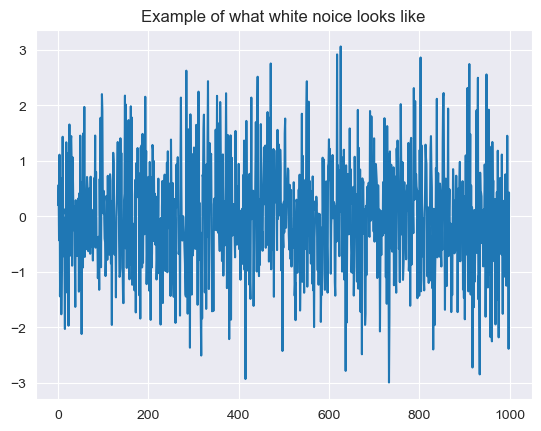

In [597]:
# Plotting white noise
white_noise = np.random.normal(loc=0, scale=1, size=1000)
# loc is mean, scale is variance
plt.plot(white_noise)
plt.title('Example of what white noice looks like')
plt.show()

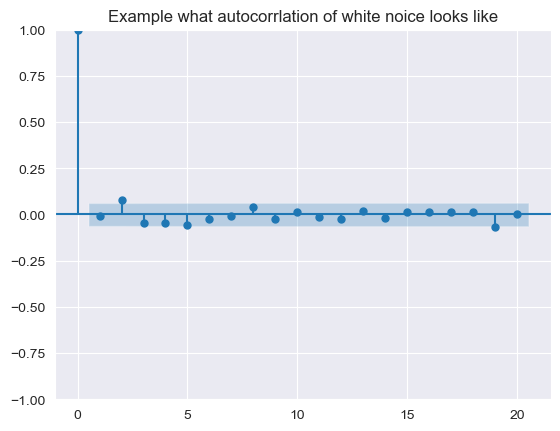

In [598]:
# Plotting autocorrelation of white noise
tsaplots.plot_acf(white_noise,lags=20)
plt.title('Example what autocorrlation of white noice looks like')
plt.show()

# Step 3: Which AR model is best ?

## Autoregressive (AR) Models

The statsmodels class ARMA has been deprecated and replaced with the slightly more general ARIMA class. After importing ARIMA, create an instance of that class called mod, with the arguments being the data that you're trying to fit, and the order of the model. 

The order (1,0,0) means you're fitting the data to an AR(1) model with only 1 lag. An order (2,0,0) would mean you're fitting the data to an AR(2) model with 2 lags. 

The middle number, d, relates to whether you take first differences of the data to make the time series stationary, like you would do with a random walk. For now, we'll assume there are no first differences so the middle number will be zero.

In the last chapter, we will give an example where we do take first differences. The third number, q, is the MA part, which will be discussed in the next chapter. Once you instantiate the class, you can use the method fit to estimate the model, and store the results in result.

In [613]:
# Fit an AR model with monthly pct data with order 12
mod = ARIMA(pct_monthly['2014':'2024'], order=(12,0,0))
res = mod.fit()

# Print out summary information on the fit
print(res.summary())

# Print out the estimate for phi
print("Estimate of L1 phi is: {}".format(res.params.iloc[1]))

                               SARIMAX Results                                
Dep. Variable:                     GT   No. Observations:                  120
Model:                ARIMA(12, 0, 0)   Log Likelihood                 139.710
Date:                Mon, 26 Feb 2024   AIC                           -251.420
Time:                        11:56:28   BIC                           -212.395
Sample:                    03-31-2014   HQIC                          -235.572
                         - 02-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.011     -0.122      0.903      -0.022       0.020
ar.L1          0.4310      0.087      4.960      0.000       0.261       0.601
ar.L2         -0.2319      0.107     -2.176      0.0

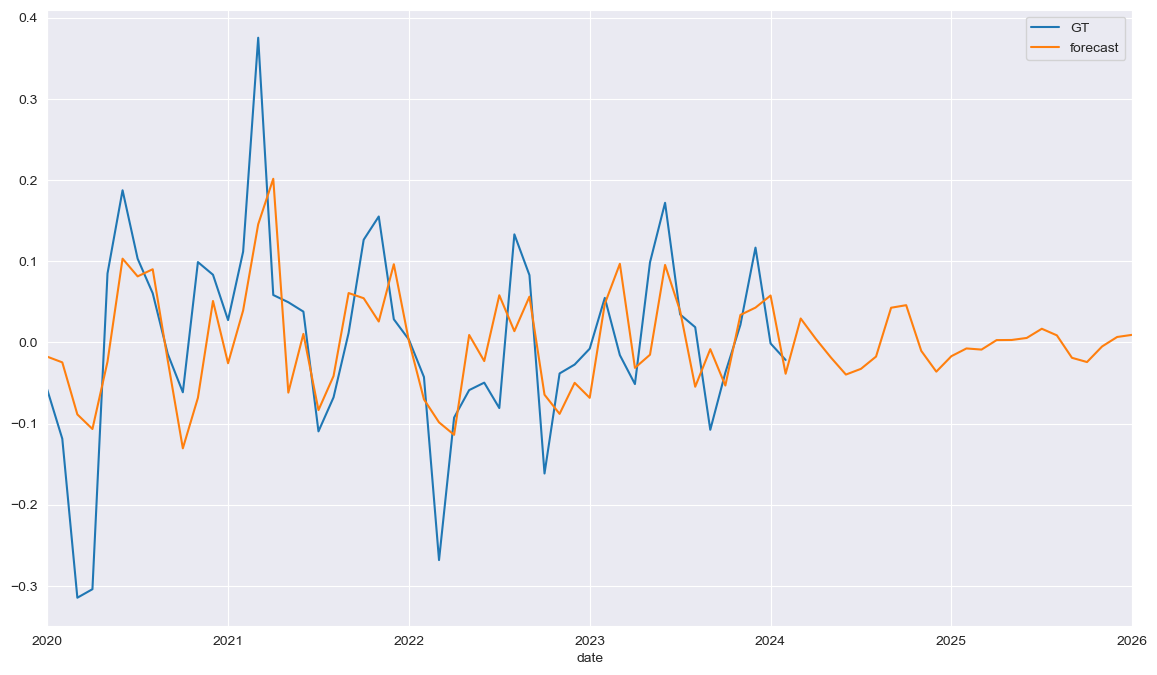

In [615]:
fig, ax = plt.subplots(figsize=(14,8))
pct_monthly['2020':'2026'].plot(ax=ax)
fig = plot_predict(res, start='2020', end='2026', alpha=None, ax=ax)
plt.show()

Estimate of phi is: 0.16007124059813566


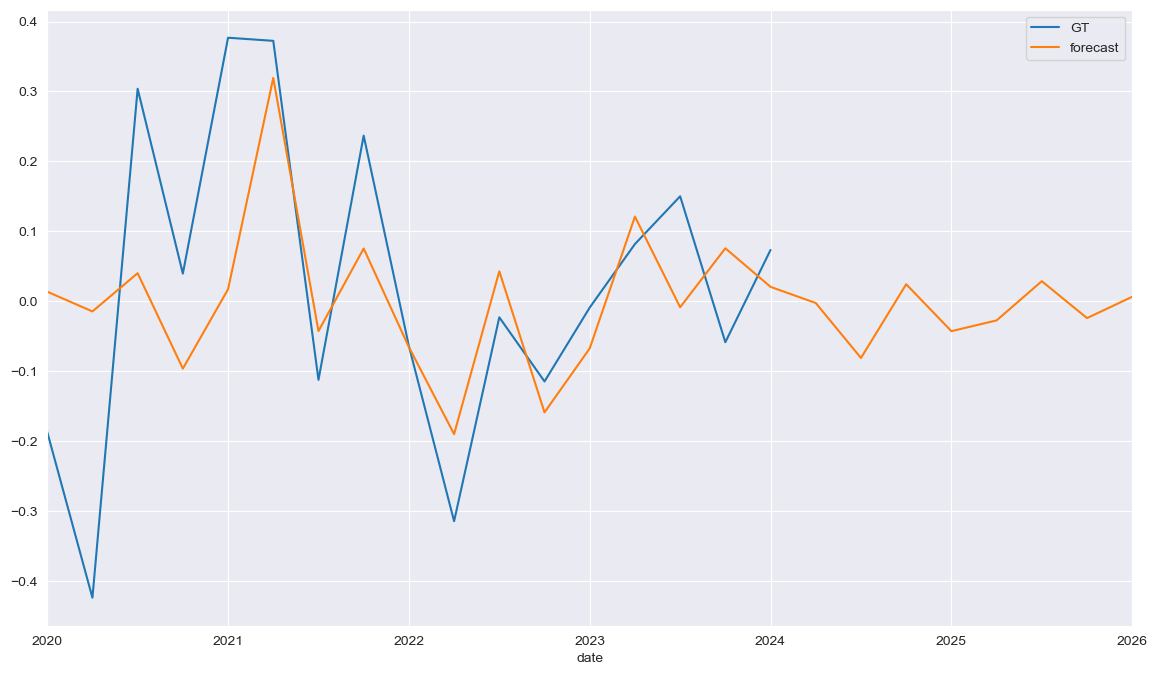

In [617]:
# Fit an AR model with monthly pct data with order 12
mod = ARIMA(pct_quarterly['2014':'2024'], order=(4,0,0))
res = mod.fit()

# Print out the estimate for phi
print("Estimate of phi is: {}".format(res.params.iloc[1]))

fig, ax = plt.subplots(figsize=(14,8))
pct_quarterly['2020':'2024'].plot(ax=ax)
fig = plot_predict(res, start='2020', end='2026', alpha=None, ax=ax)
plt.show()

## How to know which order to use ?


**1. Choosing the Right Model**
In practice, you will ordinarily not be told the order of the model that you're trying to estimate.

**2. Identifying the Order of an AR Model**
There are two techniques that can help determine the order of the AR model: The Partial Autocorrelation Function, and the Information Criteria

**3. Partial Autocorrelation Function (PACF)**
The Partial Autocorrelation Function measures the incremental benefit of adding another lag. Imagine running several regressions, where you regress returns on more and more lagged values. The coefficients in the red boxes represent the values of the partial autocorrelation function for different lags. For example, in the bottom row, the coefficient in the red box, phi 4-4, is the lag-4 value of the Partial Autocorrelation Function, and it represents **how significant adding a fourth lag is when you already have three lags**.

**4. Plot PACF in Python**
plot_pacf is the statsmodels function for plotting the partial autocorrelation function. The arguments are the same as that of the plot_acf module that you saw earlier. The input x is a series or array. The argument lags indicates how many lags of the partial autocorrelation function will be plotted. And the alpha argument sets the width of the confidence interval.

**5. Comparison of PACF for Different AR Models**
These plots show the Partial Autocorrelation Function for AR models of different orders. In the upper left, for an AR(1) model, only the lag-*1* PACF is significantly different from zero. Similarly, for an AR(2) model, two lags are different from zero, and for and AR(3), three lags are different from zero. Finally, for White Noise, there are no lags that are significantly different from zero.

**6. Information Criteria**
The more parameters in a model, the better the model will fit the data. But this can lead to overfitting of the data. The information criteria adjusts the goodness-of-fit of a model by imposing a penalty based on the number of parameters used. Two common adjusted goodness-of-fit measures are called the Akaike Information Criterion and the Bayesian Information Criterion.

**7. Information Criteria**
This is the full output from estimating an AR(2) model. The AIC and BIC are highlighted in the red box. To get the AIC and BIC statistics,

**8. Getting Information Criteria From statsmodels**
you follow the same procedure from the last section to fit the data to a model. In the last section, you learned how to get the full output using summary or just the AR parameters using the params attribute. You can also get the AIC or BIC using those attributes. In practice, the way to use the Bayesian information criterion is to fit several models, each with a different number of parameters, and choose the one with the lowest information criterion.

**9. Information Criteria**
Suppose we are given a time series of data, and unknown to us, it was simulated from an AR(3) model. Here is a plot of the BIC when we fit the data to an AR(1) up to an AR(6) model. You can see that the lowest BIC occurs for an AR(3).

/opt/anaconda3/envs/webappstockmarket/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


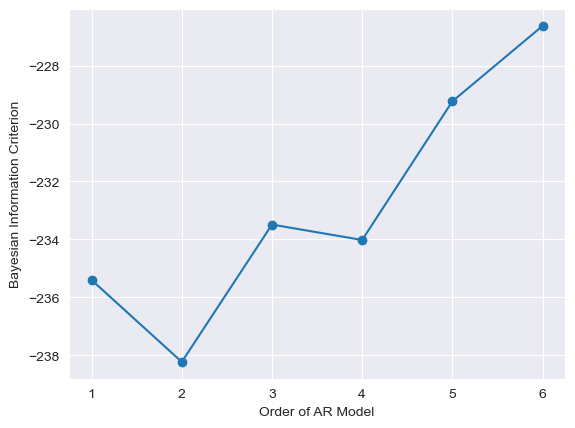

In [618]:
# Fit the data to an AR(p) for p = 0,...,6 , and save the BIC
BIC = np.zeros(7)
for p in range(7):
    mod = ARIMA(pct_monthly, order=(p,0,0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

Estimate of phi is: 0.4642837901045314


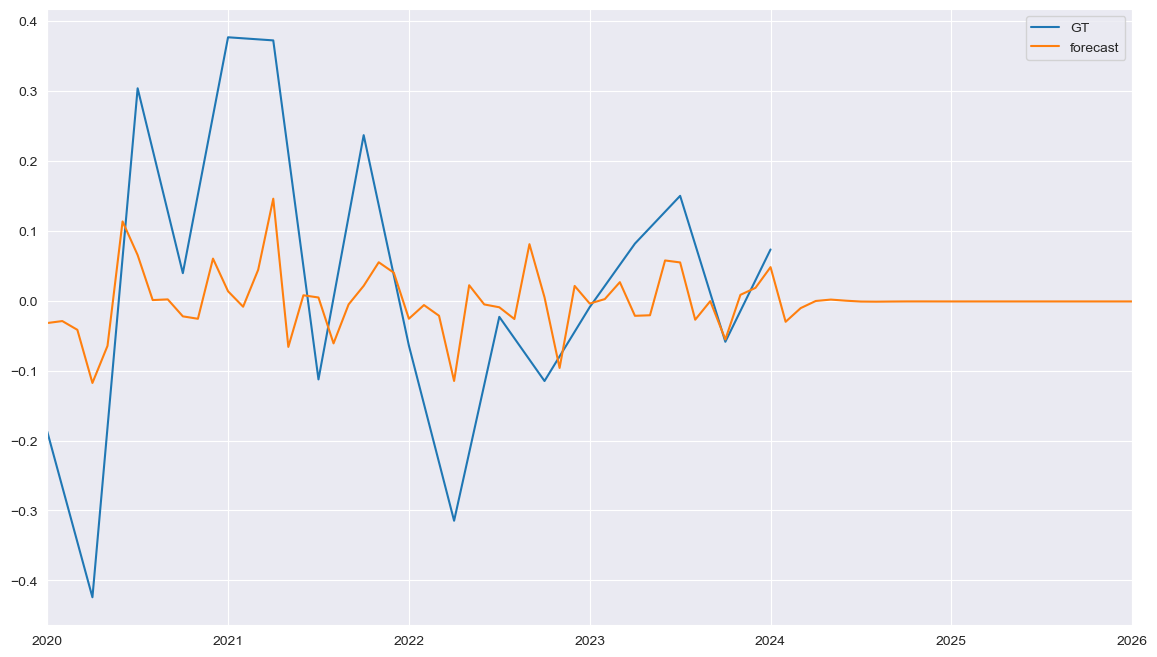

In [619]:
 # Fit an AR model
mod = ARIMA(pct_monthly['2014':'2024'], order=(2,0,0))
res = mod.fit()

# Print out the estimate for phi
print("Estimate of phi is: {}".format(res.params.iloc[1]))

fig, ax = plt.subplots(figsize=(14,8))
pct_quarterly['2020':'2024'].plot(ax=ax)
fig = plot_predict(res, start='2020', end='2026', alpha=None, ax=ax)
plt.show()

In [645]:
# # Fit the data to an AR(1) model and print AIC:
# mod_ar1 = ARIMA(marketstack_diff, order=(1,0,0))
# res_ar1 = mod_ar1.fit()
# print("The AIC for an AR(1) is: ", res_ar1.aic)
# # print("The BIC for an AR(1) is: ", res_ar1.bic)
# 
# # Fit the data to an AR(2) model and print AIC:
# mod_ar2 = ARIMA(marketstack_diff, order=(2,0,0))
# res_ar2 = mod_ar2.fit()
# print("The AIC for an AR(2) is: ", res_ar2.aic)
# # print("The BIC for an AR(2) is: ", res_ar2.bic)
# 
# # Fit the data to an ARMA(1,1) model and print AIC:
# mod_arma11 = ARIMA(marketstack_diff, order=(1,0,1))
# res_arma11 = mod_arma11.fit()
# print("The AIC for an ARMA(1,1) is: ", res_arma11.aic)
# # print("The BIC for an ARMA(1,1) is: ", res_arma11.bic)

In [551]:
decomposition = sm.tsa.seasonal_decompose(marketstack_ma, extrapolate_trend='freq')
fig = decomposition.plot()
plt.figure(figsize=(20,15))
plt.show()

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

#### Making a non stationary time series stationary

In [318]:
quarters = marketstack_ma['GT'].resample(rule='QE').mean()
quarters = quarters.diff(6).dropna()
quarters.head()

date
2015-12-31    5.980634
2016-03-31    4.019367
2016-06-30    5.990654
2016-09-30    1.478249
2016-12-31    2.369823
Freq: QE-DEC, Name: GT, dtype: float64

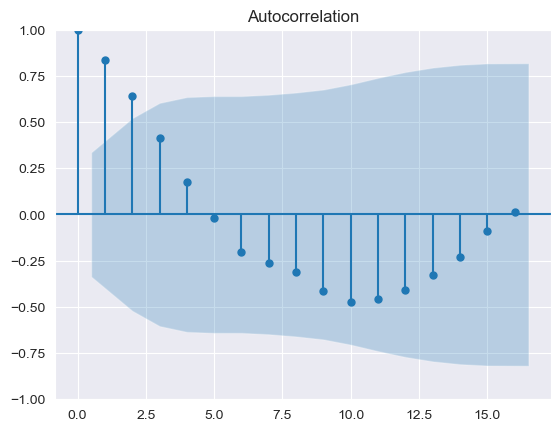

In [319]:
fig = tsaplots.plot_acf(quarters, alpha=0.05)
plt.show()

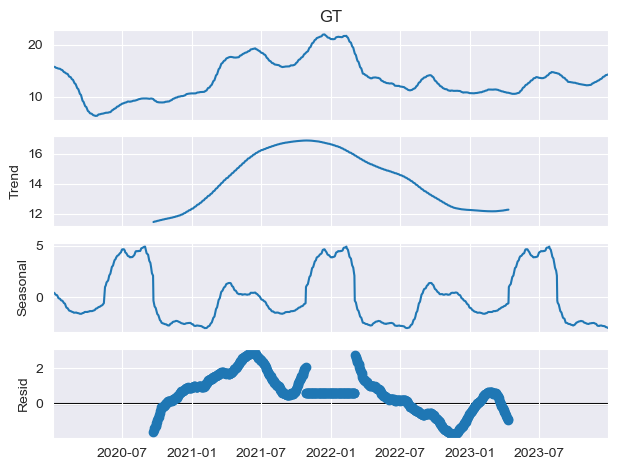

In [348]:
decomposed_google_volume = sm.tsa.seasonal_decompose(marketstack_ma['2020': '2023']["GT"].dropna(), period=365) # The frequncy is annual
figure = decomposed_google_volume.plot()
plt.show()

#### Estimating an AR model (Autoregression)

In [321]:
marketstack_pct.head()

symbol,GT,NDAQ
date,,
2014-05-31,-0.027903,-0.030306
2014-06-30,-0.001341,0.023683
2014-07-31,0.057093,0.042598
2014-08-31,-0.026500,0.071211
2014-09-30,-0.052960,0.038378


# References

In [ ]:
https://community.plotly.com/t/plot-pacf-plot-acf-autocorrelation-plot-and-lag-plot/24108/2
https://otexts.com/fpp2/seasonal-arima.html
https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Time%20Series%20Forecastings.ipynb
https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3